# ID5059 P2 Group Project

## Imports

In [86]:
# use pip to install all the libraries we need
import sys
# !{sys.executable} -m pip install numpy pandas matplotlib scikit-learn seaborn | grep -v 'already satisfied'

# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore') # remove warnings

## Read in the data

In [87]:
# read the data, dropping the ID column, as this is duplicated by pandas
raw_training_data = pd.read_csv(r"train.csv").drop(columns=["id"])
raw_test_data = pd.read_csv(r"test.csv").drop(columns=["id"])

# to test out imputation methods, we will need to make a copy of the training data so we don't change it

# copy the raw training data
copy_raw_training_data = raw_training_data.copy()

# separate out the independent variables from the target
X_copy = copy_raw_training_data.drop(labels=['Status'], axis=1)
Y_copy = copy_raw_training_data["Status"]

## Data analysis & Exploration

In [88]:
print(f"Train set shape: {raw_training_data.shape}") 
# print(f"Test set shape: {raw_test_data.shape}") # doesn't have the 'Status' column
# print()

Train set shape: (7905, 19)


In [89]:
print(f"Null count for both data sets:")
print(pd.concat([raw_training_data.isnull().sum().astype(float), raw_test_data.isnull().sum().astype(int)], axis=1).rename(columns={0: 'Train Set', 1: 'Test Set'}))

Null count for both data sets:
               Train Set  Test Set
N_Days               0.0       0.0
Drug                 0.0       0.0
Age                  0.0       0.0
Sex                  0.0       0.0
Ascites              0.0       0.0
Hepatomegaly         0.0       0.0
Spiders              0.0       0.0
Edema                0.0       0.0
Bilirubin            0.0       0.0
Cholesterol          0.0       0.0
Albumin              0.0       0.0
Copper               0.0       0.0
Alk_Phos             0.0       0.0
SGOT                 0.0       0.0
Tryglicerides        0.0       0.0
Platelets            0.0       0.0
Prothrombin          0.0       0.0
Stage                0.0       0.0
Status               0.0       NaN


In [90]:
print("Summary of numerical features:")
print(raw_training_data.describe().round(3))

Summary of numerical features:
         N_Days        Age  Bilirubin  Cholesterol   Albumin    Copper  \
count  7905.000   7905.000   7905.000     7905.000  7905.000  7905.000   
mean   2030.173  18373.146      2.594      350.562     3.548    83.903   
std    1094.234   3679.959      3.813      195.379     0.346    75.899   
min      41.000   9598.000      0.300      120.000     1.960     4.000   
25%    1230.000  15574.000      0.700      248.000     3.350    39.000   
50%    1831.000  18713.000      1.100      298.000     3.580    63.000   
75%    2689.000  20684.000      3.000      390.000     3.770   102.000   
max    4795.000  28650.000     28.000     1775.000     4.640   588.000   

        Alk_Phos      SGOT  Tryglicerides  Platelets  Prothrombin     Stage  
count   7905.000  7905.000        7905.00   7905.000     7905.000  7905.000  
mean    1816.745   114.605         115.34    265.229       10.629     3.033  
std     1903.751    48.791          52.53     87.466        0.782   

In [91]:
print(pd.concat([raw_training_data.nunique().rename('Unique count'), raw_training_data.dtypes.rename('Data type'), ], axis=1))

               Unique count Data type
N_Days                  461     int64
Drug                      2    object
Age                     391     int64
Sex                       2    object
Ascites                   2    object
Hepatomegaly              2    object
Spiders                   2    object
Edema                     3    object
Bilirubin               111   float64
Cholesterol             226   float64
Albumin                 160   float64
Copper                  171   float64
Alk_Phos                364   float64
SGOT                    206   float64
Tryglicerides           154   float64
Platelets               227   float64
Prothrombin              49   float64
Stage                     4   float64
Status                    3    object


In [92]:
print("Proportion of each response variable:")
print(raw_training_data['Status'].value_counts() / np.shape(raw_training_data)[0])

Proportion of each response variable:
Status
C     0.628083
D     0.337128
CL    0.034788
Name: count, dtype: float64


##### Unique Drug Values

In [93]:
# Check unique values in the 'Drug' column
unique_drugs = raw_training_data['Drug'].unique()
print("Unique drugs in the dataset:", unique_drugs)

Unique drugs in the dataset: ['D-penicillamine' 'Placebo']


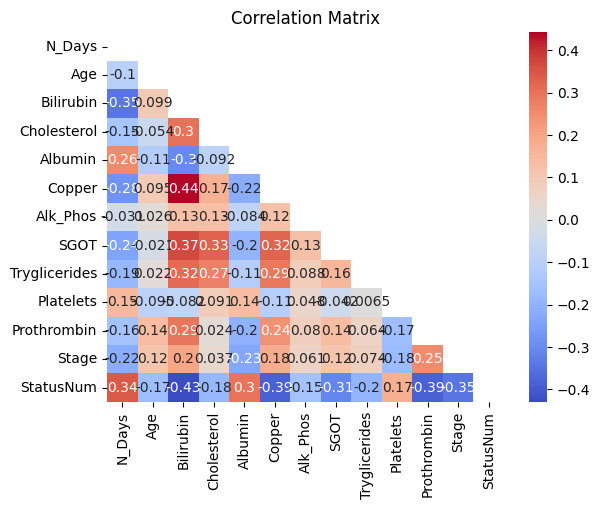

In [94]:
# convert Status response to numerical for correlation exploration
response_map = {'D':0, 'CL':1, 'C':2}
raw_training_data['StatusNum'] = raw_training_data['Status'].map(response_map)

matrix = raw_training_data[raw_training_data.select_dtypes(include=['int64', 'float64']).columns].corr() # define correlation matrix
raw_training_data = raw_training_data.drop(columns=['StatusNum']) # drop the numerical Status label
diagmask = np.triu(np.ones_like(matrix)) # create mask to only map lower diagonal
sns.heatmap(matrix, annot=True, cmap='coolwarm', mask=diagmask) # plot the heatmap
plt.title('Correlation Matrix')
plt.show()

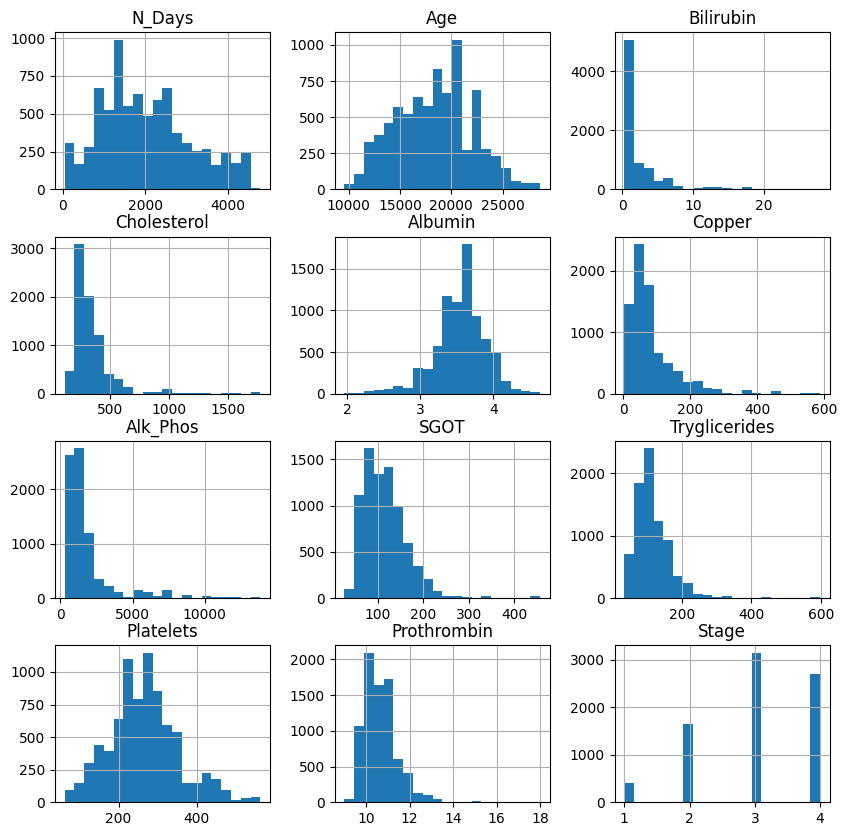

In [95]:
# plot histograms for numerical variables
raw_training_data.hist(bins=20, figsize=(10, 10))
plt.show()

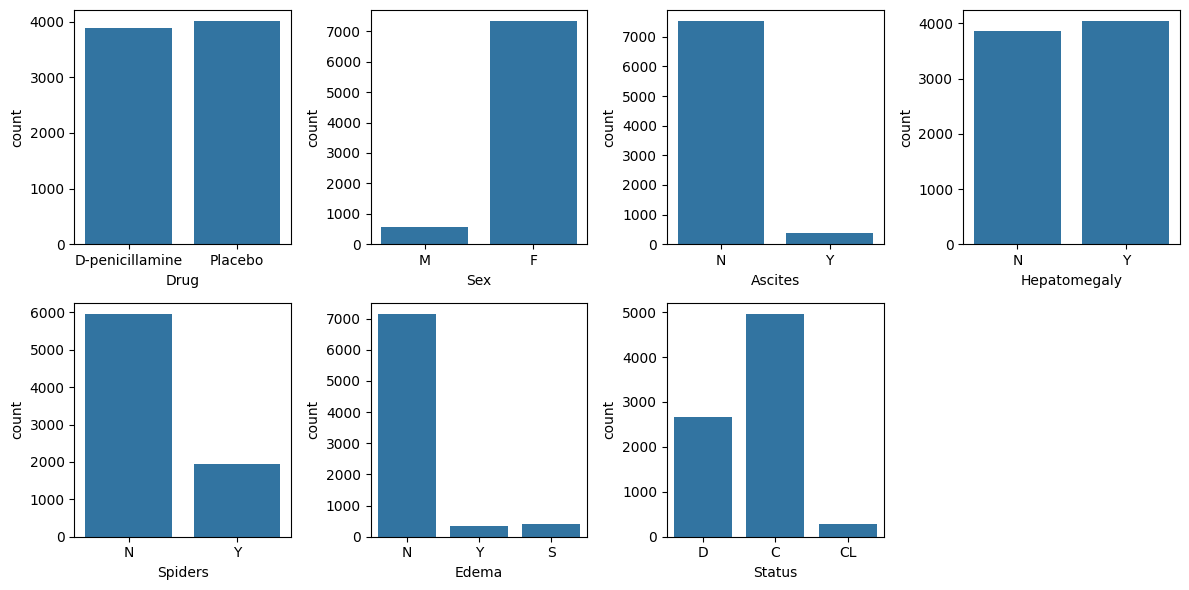

In [96]:
# plot countplots for categorical variables
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6)) # initialise figure and axes
axs = axs.flatten()

categorical = raw_training_data.select_dtypes(include='object').columns # store the categorical variables
for i in range(len(categorical)): # loop over categorical variables
    sns.countplot(x=categorical[i], data=raw_training_data, ax=axs[i]) # countplot for each variable
[ax.remove() for ax in axs[7:]] # remove final axis
plt.tight_layout()

##### Class Distribution Visualization

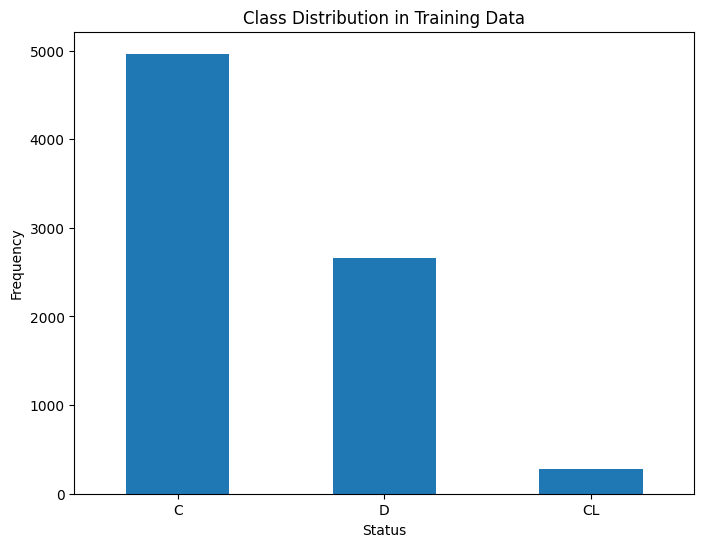

In [97]:
plt.figure(figsize=(8, 6))
raw_training_data['Status'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

##### Feature Distribution by Class

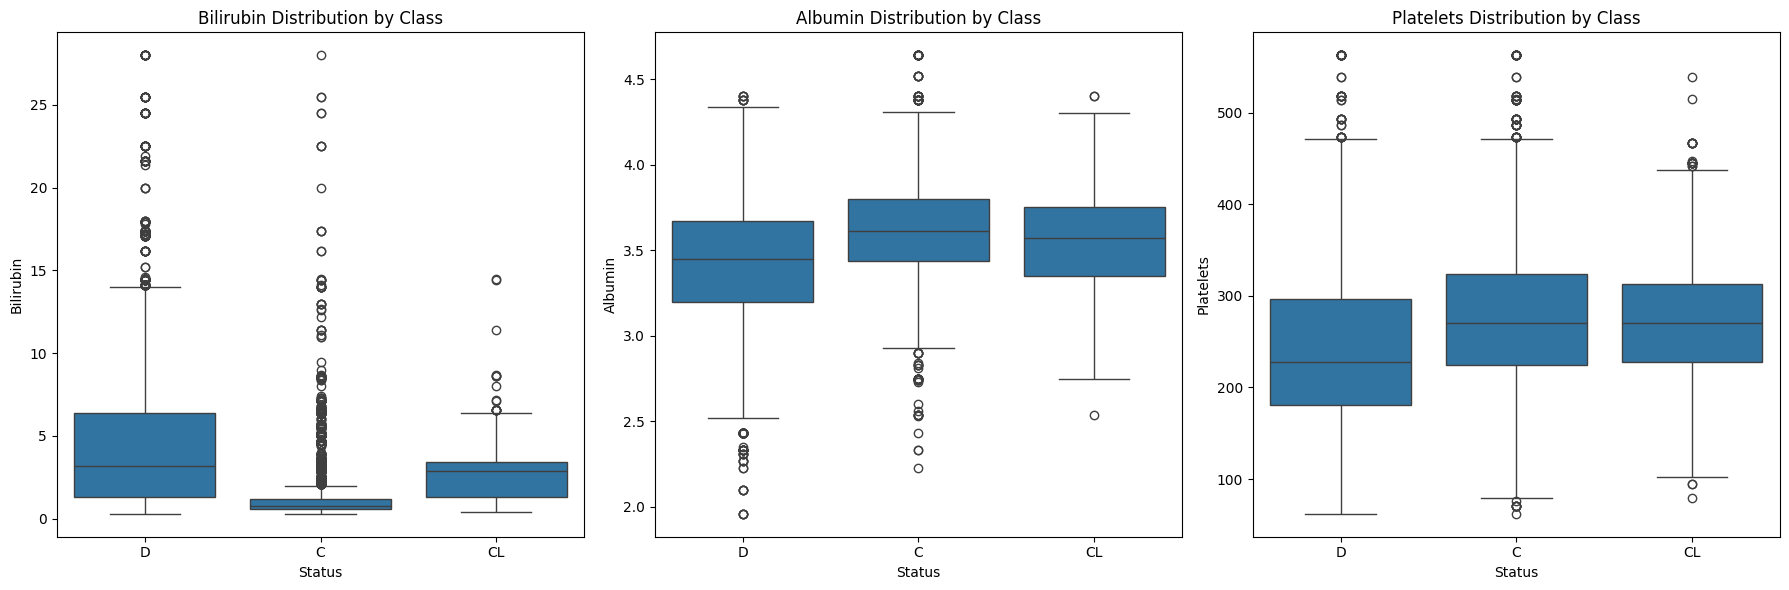

In [98]:
# Feature Distribution by Class for 'Bilirubin', 'Albumin', and 'Platelets'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(ax=axes[0], x='Status', y='Bilirubin', data=raw_training_data)
sns.boxplot(ax=axes[1], x='Status', y='Albumin', data=raw_training_data)
sns.boxplot(ax=axes[2], x='Status', y='Platelets', data=raw_training_data)
axes[0].set_title('Bilirubin Distribution by Class')
axes[1].set_title('Albumin Distribution by Class')
axes[2].set_title('Platelets Distribution by Class')
plt.tight_layout()
plt.show()

##### Correlation Analysis Extended

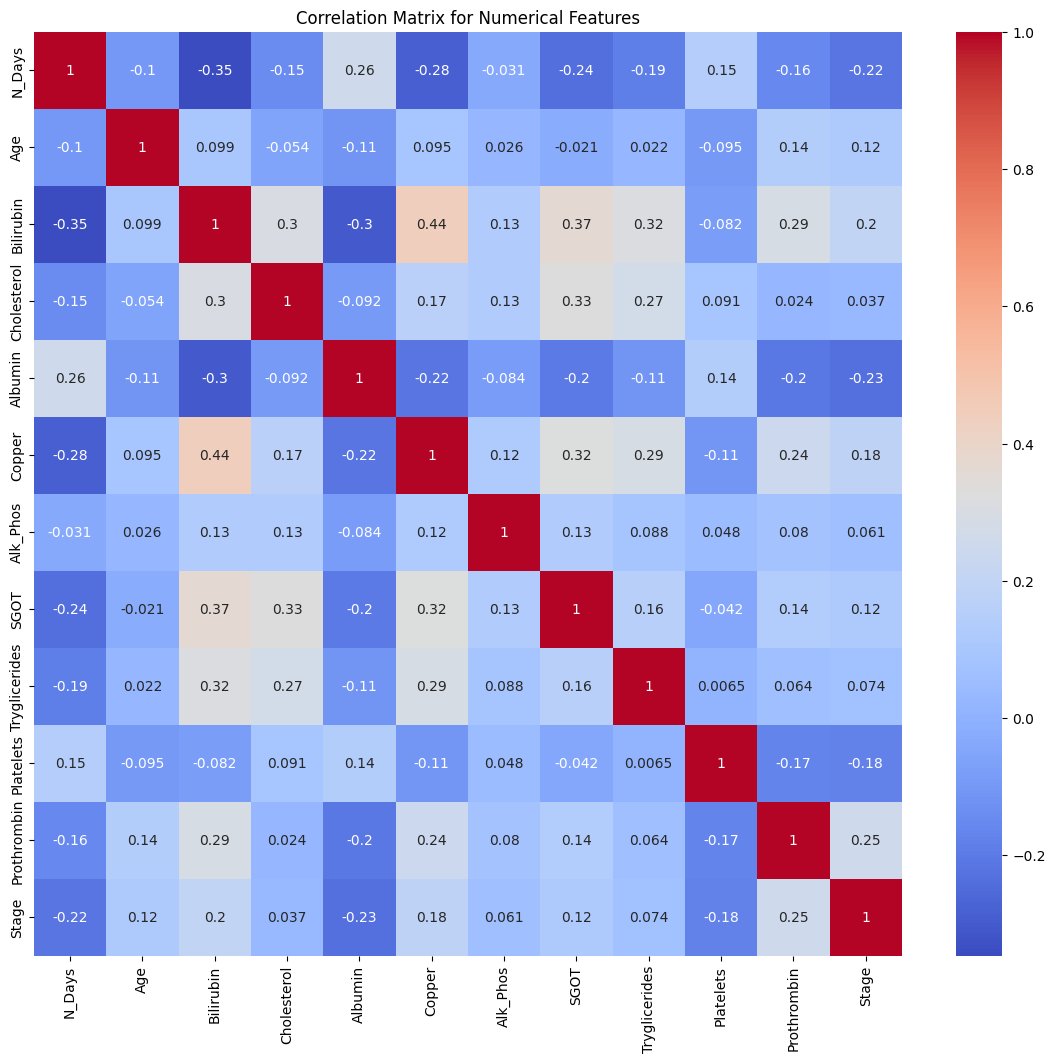

In [99]:
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

plt.figure(figsize=(14, 12))
sns.heatmap(raw_training_data[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

##### Outlier Detection for Key Numerical Features

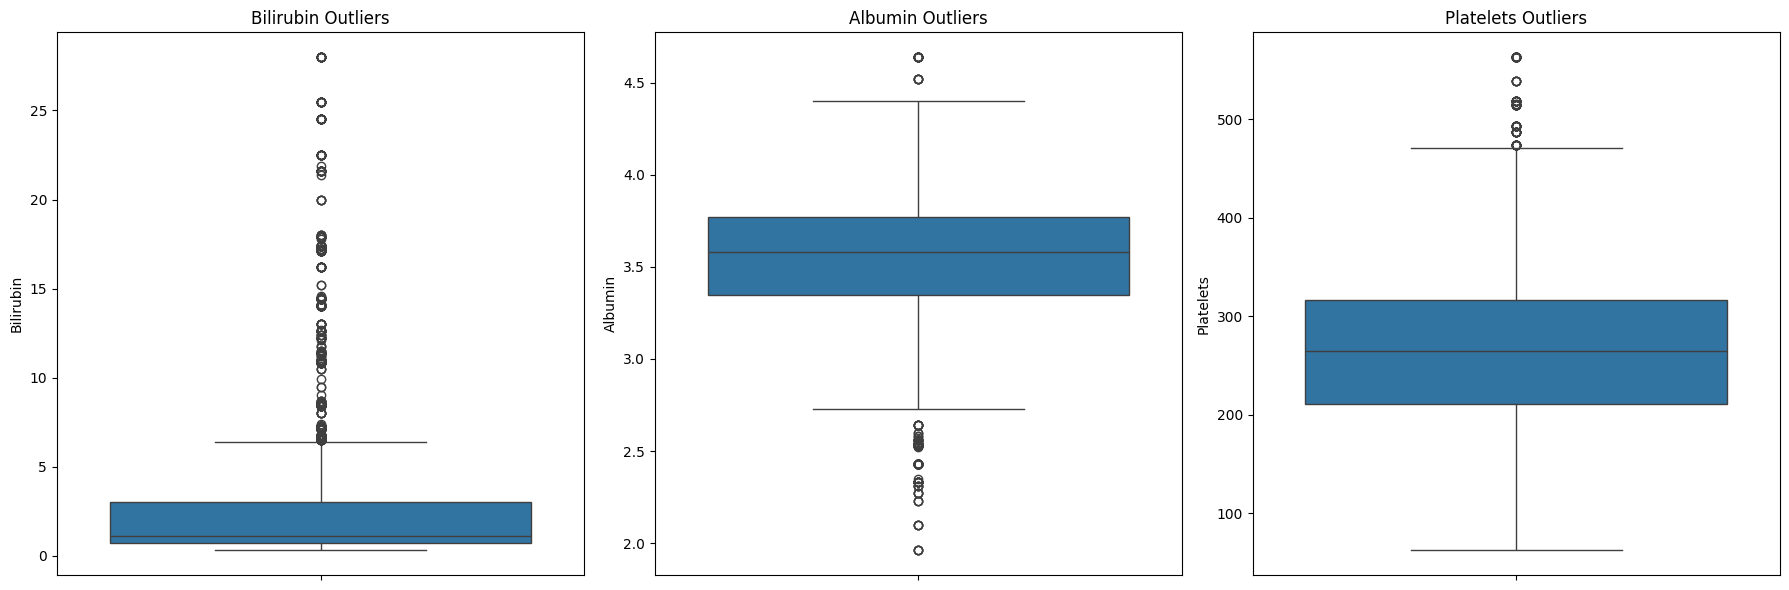

In [100]:
# Outlier Detection for 'Bilirubin', 'Albumin', and 'Platelets'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(ax=axes[0], data=raw_training_data['Bilirubin'], orient="v")
sns.boxplot(ax=axes[1], data=raw_training_data['Albumin'], orient="v")
sns.boxplot(ax=axes[2], data=raw_training_data['Platelets'], orient="v")
axes[0].set_title('Bilirubin Outliers')
axes[1].set_title('Albumin Outliers')
axes[2].set_title('Platelets Outliers')
plt.tight_layout()
plt.show()

##### Exploring Categorical Features

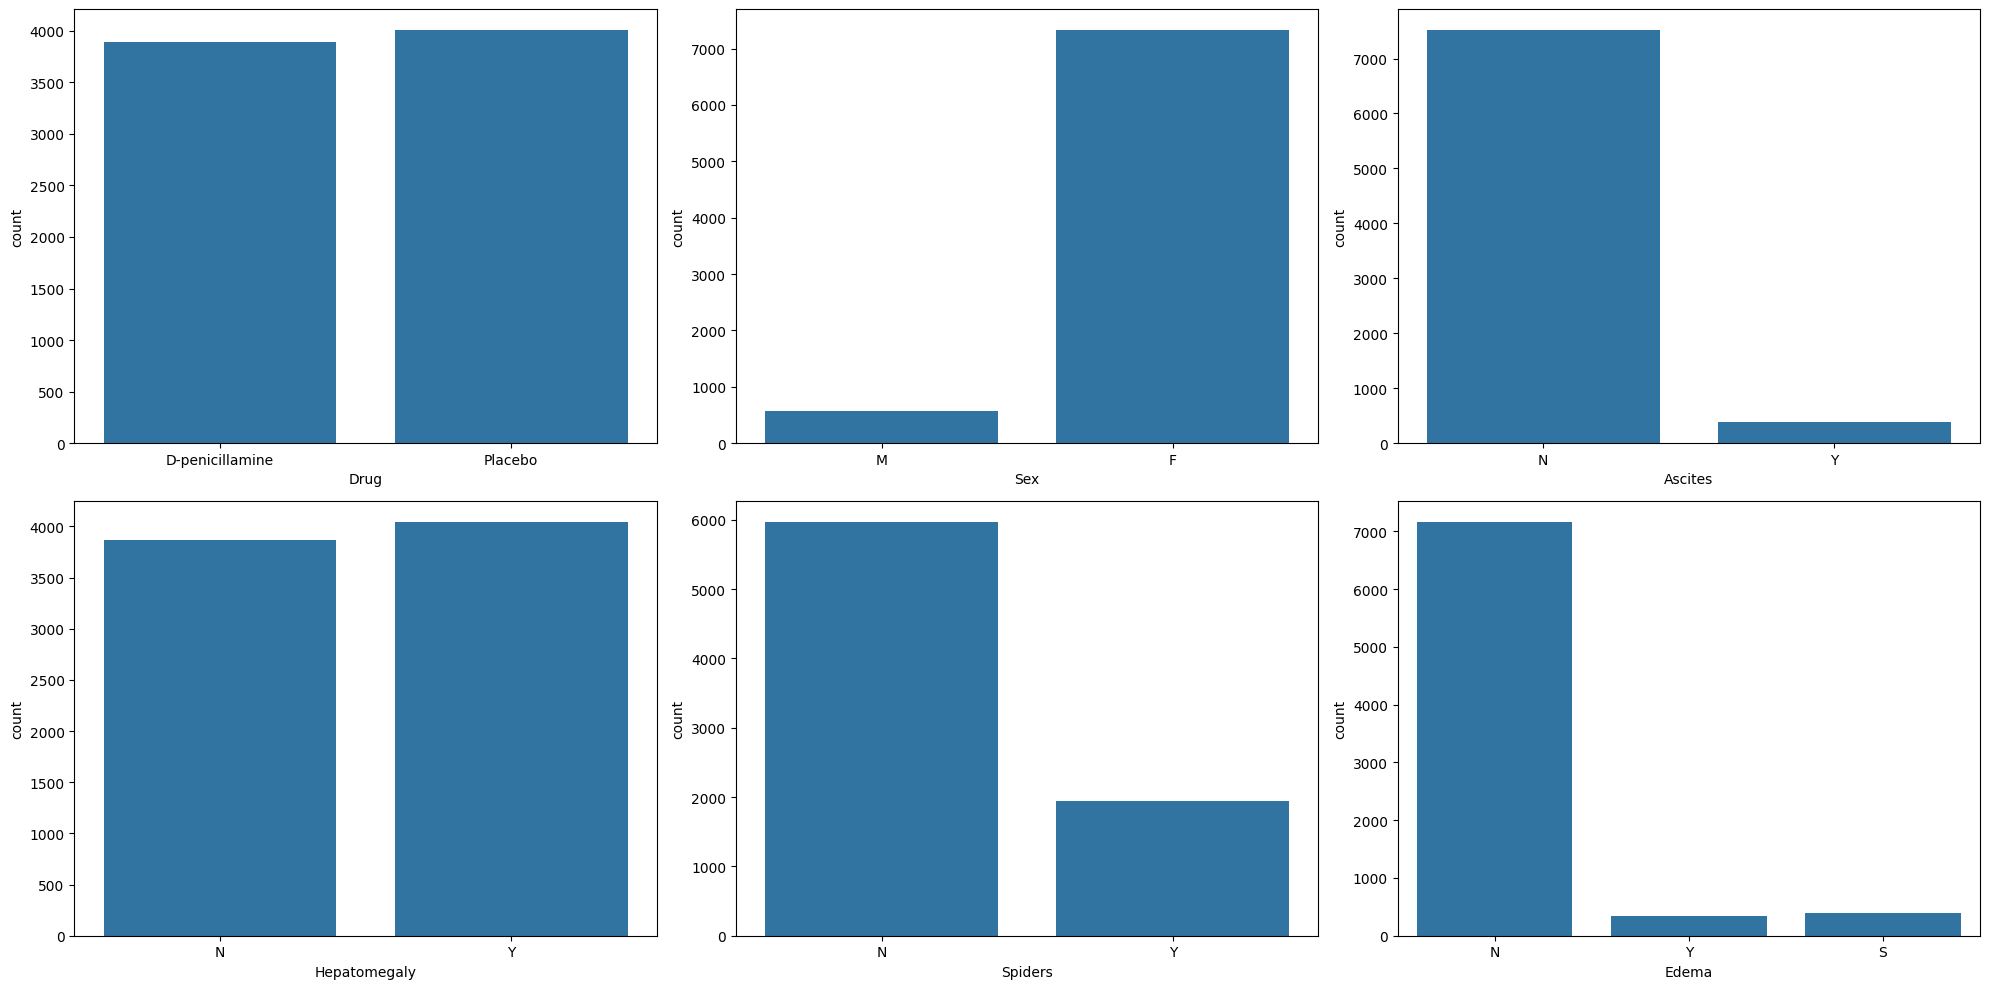

In [101]:
# Categorical Features Distribution
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, cat_feature in enumerate(categorical_features):
    sns.countplot(x=cat_feature, data=raw_training_data, ax=axes[i])
plt.tight_layout()
plt.show()

##### Interaction Effects Between Features

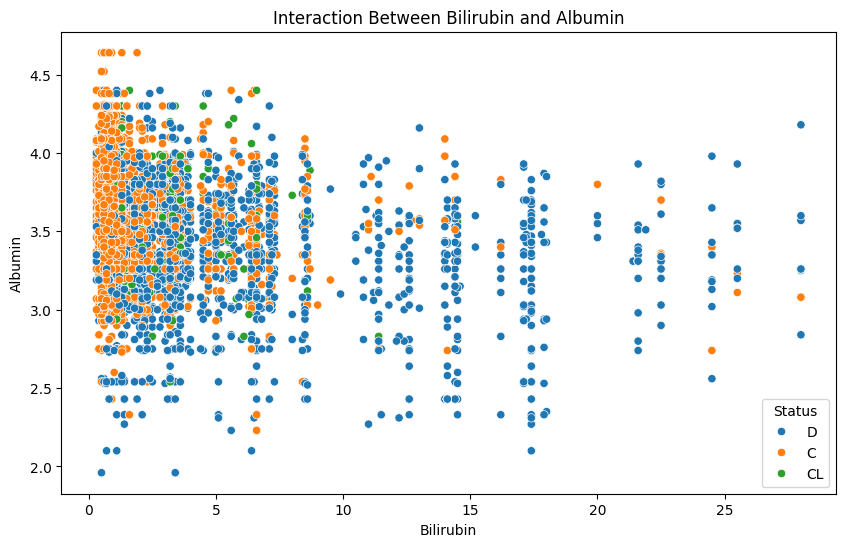

In [102]:
# Interaction Effects Between 'Bilirubin' and 'Albumin'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bilirubin', y='Albumin', hue='Status', data=raw_training_data)
plt.title('Interaction Between Bilirubin and Albumin')
plt.show()

##### Feature Distribution Comparison Between Classes

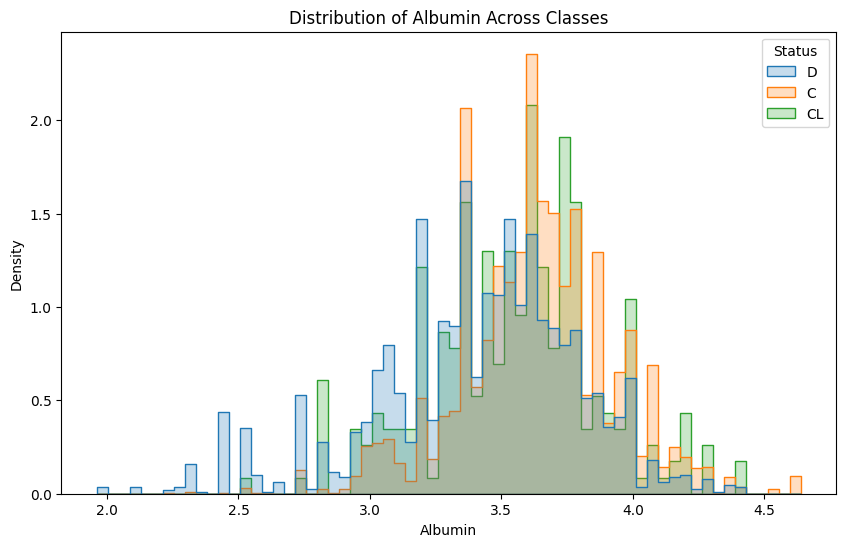

In [103]:
# Distribution of 'Albumin' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Albumin', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Albumin Across Classes')
plt.show()

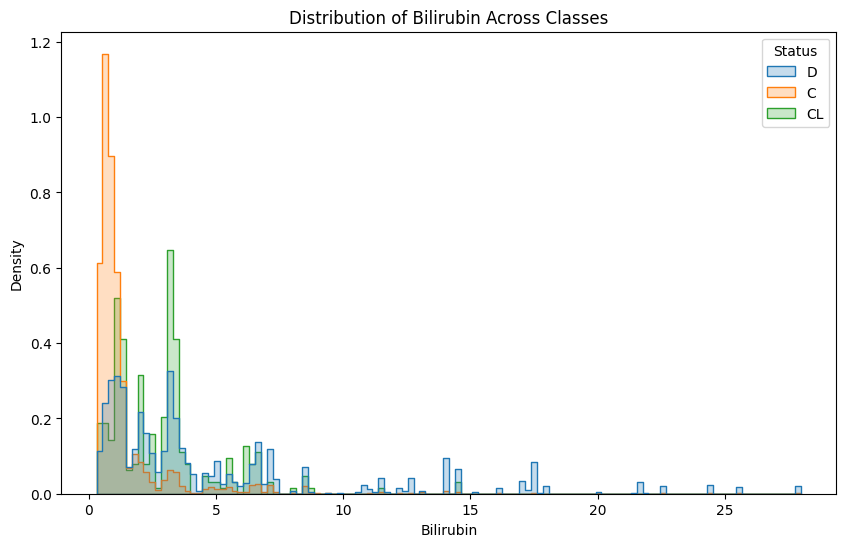

In [104]:
# Distribution of 'Bilirubin' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Bilirubin', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Bilirubin Across Classes')
plt.show()

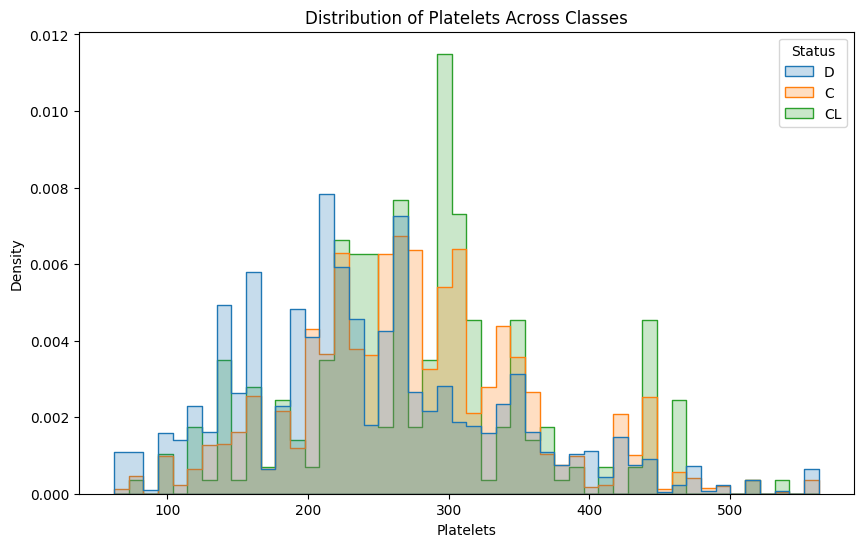

In [105]:
# Distribution of 'Platelets' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Platelets', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Platelets Across Classes')
plt.show()

##### Advanced Visualization of Categorical Variables

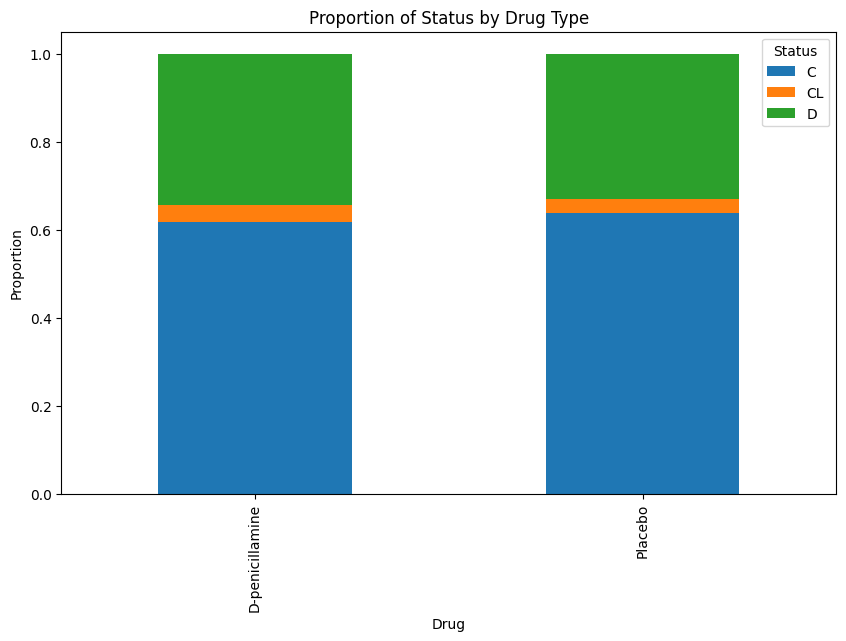

In [106]:
# Stacked Bar Chart for 'Drug' and 'Status'
cross_tab = pd.crosstab(index=raw_training_data['Drug'], columns=raw_training_data['Status'], normalize='index')
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Status by Drug Type')
plt.ylabel('Proportion')
plt.show()

## Imputation Methods

We now want to explore different imputation methods which can be used during the preprocessing stage. Since the data we have been given does not have any missing values, we will have to make a copy of it, remove some entries manually, then use various methods to impute the data back and assess the effectiveness of each one. First we define some useful functions.

### Functions for Imputation

In [107]:
def add_missing_values(X_full, Y_full, missing_rate):
    """
    Takes a dataframe and adds in some missing values.

    Parameters:
    - X_full: a dataframe containing all columns with independent variables
    - Y_full: a dataframe containing the response variable column only
    - missing_rate: a float between 0 and 1 which specifies the proportion of lines which should have missing values

    Returns:
    - X_missing: the dataframe X_full but with some missing values
    - Y_missing: an exact copy of Y_full
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    """
    # set a seed for reproducibility
    np.random.seed(24)
    
    # copy the input dataframes
    X_missing = X_full.copy()
    y_missing = Y_full.copy()

    # create empty dictionary to store values of entries before setting them to nan
    actual_entries_store = {}

    # remove a percentage of entries in each column at random, specified by missing_rate
    for col in X_missing.columns:
        index_list = X_missing.sample(frac=missing_rate+random.uniform(-0.01, 0.01)).index  # sample a proportion of the indices within the column, with a random component for the rate
        actual_entries_store[col] = []
        for value in index_list:
            actual_entries_store[col].append(X_missing.loc[value, col])   # store the actual entries in the dictionary
        X_missing.loc[index_list, col] = np.nan # replace the values with nan

    return X_missing, y_missing, actual_entries_store

In [108]:
def get_imputed_values(imputed_data, null_entries):
    """
    Gets the value of all the imputed entries and outputs them in a dictionary.
    
    Parameters:
    - imputed_data: the dataframe containing some actual values and some imputed values
    - null_entries: the locations of all the entries which were null before imputation

    Returns:
    - imputed_entries_store: dictionary containing all imputed entries
    """
    imputed_entries_store = {} # create dictionary for storing the actual values in the locations that are removed
    
    for row, col in null_entries: # loop over every removed entry:
        col_name = imputed_data.columns[col] # store column name of current null entry
        if col_name not in imputed_entries_store: # check if column name is already in the dictionary
            imputed_entries_store[col_name] = [] # if not already in dictionary, create empty list
        imputed_entries_store[col_name].append(imputed_data.iloc[row, col])# add actual value to the list for correct column

    return imputed_entries_store

In [109]:
def calc_num_metrics(actual_entries_store, imputed_entries_store, num_cols):
    """
    Calculates performance metric RMSE for numerical variables for the imputation method.
    
    Parameters:
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    - imputed_entries_store: dictionary containing all imputed entries, indexed the same as actual_entries_store
    - num_cols: list of the numerical columns in the data frame
    
    Returns:
    - Data frame as a string showing the RMSE for the imputation method for each numerical variable
    """
    numerical_data = []
    for col_name, actual_vals in actual_entries_store.items(): # loop over all variables and actual values
        if col_name in num_cols: # if the current column is numerical:
            # change imputed and actual values to be numeric
            imputed_vals = pd.to_numeric(imputed_entries_store.get(col_name, []))
            actual_vals = pd.to_numeric(actual_vals)
            numerical_data.append({"Variable": col_name, "RMSE": round(mean_squared_error(actual_vals, imputed_vals, squared=False),3)}) # add the column name and its RMSE
    
    return pd.DataFrame(numerical_data)

In [110]:
def calc_categorical_metrics(actual_entries_store, imputed_entries_store, categorical_cols):
    """
    Calculates performance metric accuracy and F1 score for categorical variables for the imputation method.
    
    Parameters:
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    - imputed_entries_store: dictionary containing all imputed entries, indexed the same as actual_entries_store
    - categorical_cols: list of the categorical columns in the data frame
    
    Returns:
    - Data frame as a string showing the accuracy and F1 score for the imputation method for each categorical variable
    """
    categorical_data = []
    for col_name in categorical_cols: # loop over all categorical variables
        # change imputed and actual values to be a string
        imputed_vals = [str(val) for val in imputed_entries_store.get(col_name, [])]
        actual_vals = [str(val) for val in actual_entries_store[col_name]]
        accuracy = accuracy_score(actual_vals, imputed_vals) # calculate accuracy score
        precision = precision_score(actual_vals, imputed_vals, average='weighted') # calculate precision score
        recall = recall_score(actual_vals, imputed_vals, average='weighted') # calculate recall score
        f1 = f1_score(actual_vals, imputed_vals, average='weighted') # calculate F1 score
        categorical_data.append({"Variable": col_name, "Accuracy": round(accuracy, 3), "Precision": round(precision, 3),"Recall": round(recall, 3),"F1 Score": round(f1, 3)}) # add the column name and its accuracy, precision, recall, and F1 score    
    return pd.DataFrame(categorical_data)

In [111]:
def numerical_encode(X):
    """
    Encodes the categorical variables in a given dataframe numerically.
    
    Parameters:
    - X: dataframe, should have columns labelled "Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"
    
    Returns:
    - X_encoded: dataframe with categorical variables encoded numerically
    """

    # make a copy of the dataframe
    X_encoded = X.copy()

    # specify how each numerical column should be encoded
    encodings = {
        "Drug": {"Placebo": 0, "D-penicillamine": 1},
        "Sex": {"F": 0, "M": 1},
        "Ascites": {"N": 0, "Y": 1},
        "Hepatomegaly": {"N": 0, "Y": 1},
        "Spiders": {"N": 0, "Y": 1},
        "Edema": {"N": 0, "Y": 1, "S": 2}
    }

    # replace the values in categorical columns by their encoded values
    X_encoded = X_encoded.replace(encodings)

    # output the encoded dataframe
    return X_encoded

In [112]:
# specify the inverse of the encoding before the function, since 'decodings' is later used outside the function as well 
decodings = {"Drug": {0: "Placebo", 1: "D-penicillamine"},
        "Sex": {0: "F", 1: "M"},
        "Ascites": {0: "N", 1: "Y"},
        "Hepatomegaly": {0: "N", 1: "Y"},
        "Spiders": {0: "N", 1: "Y"},
        "Edema": {0: "N", 1: "Y", 2: "S"}}

def reverse_numerical_encode(X):
    """
    Reverses the numerical encoding process by replacing numerical values in categorical columns with the closest category.
    
    Parameters:
    - X: dataframe which has its categorical columns encoded
    
    Returns:
    - X_decoded: dataframe with categorical columns decoded
    """

    # make a copy of the input dataframe
    X_decoded = X.copy()

    # replace each categorical column with numbers closest to the ones in the list above
    for col in decodings:
        new_col = []                            # stores a replacement column with numbers that correspond to decodings
        for entry in X_decoded[col]:
            closest_val = 0                     # stores the closest value so far, returns 0 if entry is nan
            min_dist = 100                      # stores highscore of minimum distance, starts very high to ensure it's overtaken
            for option in decodings[col]:
                dist = abs(option - entry)      # calculate the distance of the given entry to each option
                if dist < min_dist:
                    closest_val = option        # updates closest value and minimum distance if it's a new highscore
                    min_dist = dist
            new_col.append(closest_val)         # adds the final closest value to the new column
        new_col_df = pd.DataFrame(new_col)      # makes the replacement column into a dataframe and replaces the old column with it
        X_decoded[col] = new_col_df

    # apply the reverse encoding now that all entries are options for categories
    X_decoded = X_decoded.replace(decodings)

    # output the decoded dataframe
    return X_decoded

In [113]:
def predict_imputed_model(X, Y, raw_data, cat_cols):
    """
    Creates a decision tree model using the input data set by encoding categorical columns.
    Stores the csv of predicitons for kaggle submission.
    
    Parameters:
    - X: data set, excluding the response variable
    - Y: response variable of data set
    - raw_data: dataframe to apply the classifier to and get predicted probabilities
    - cat_cols: columns which contain categorical data
    
    Returns:
    - Stores the csv file in current directory when 'predictions.to_csv("predictions.csv", index=False)' is run.
    """

    X_copy = X.copy()
    Y_copy = Y.copy()
    raw_data_copy = raw_data.copy()

    X_encoded = pd.get_dummies(X_copy, columns=cat_cols)
    classifier = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
    classifier.fit(X_encoded, Y_copy)
    predictions = pd.DataFrame(classifier.predict_proba(raw_data_copy), columns=['Status_C', 'Status_CL', 'Status_D'])
    # Use the code 'predictions.to_csv("predictions.csv", index=False)' to convert to a csv file for submission to kaggle
    return # predictions.to_csv("predictions.csv", index=False) **REMOVE # to save in directory**

### Imputation method comparison

Now we can prepare our copy of the training data for our imputation models.
* Store a lists of numerical and categorical column names
* Scale the numerical data using StandardScaler
* Apply the "add_missing_values" function to the copy of the training data
* Store the locations of the null entries

In [114]:
# set random seed for reproducability
random.seed(24)

# store the names of all categorical and numerical columns (excluding the response variable)
categorical_cols = [col for col in X_copy.select_dtypes(include=['object']).columns.tolist()]
num_cols = [x for x in X_copy.columns if x not in categorical_cols]

# scale the numerical data using StandardScaler
scaler = StandardScaler()
X_copy_num = X_copy.drop(categorical_cols, axis=1)
X_copy_num_scaled = pd.DataFrame(scaler.fit_transform(X_copy_num), columns=X_copy_num.columns)

# replace the numerical columns in X_copy with the scaled versions
for col in X_copy.columns:
    if col in X_copy_num_scaled.columns:
        X_copy[col] = X_copy_num_scaled[col]

# apply the add_missing_values function to our data
X_miss, Y_miss, actual_entries_X = add_missing_values(X_copy, Y_copy, 0.05)

# create a list to store all of the entries which are null: (row, column)
null_entries_X = [(row_index, col_index) 
                for row_index, row in enumerate(X_miss.values) 
                for col_index, val in enumerate(row) 
                if pd.isnull(val)]
#---------------------------------------------------------------------------------------------------------------------------
# Below is code to convert the test data to be used in the 'predict_imputed_model' function
raw_test_data_imputation = raw_test_data.copy()

# scale the numerical data using StandardScaler
raw_test_data_imputation_num = raw_test_data_imputation.drop(categorical_cols, axis=1)
raw_test_data_imputation_scaled = pd.DataFrame(scaler.fit_transform(raw_test_data_imputation_num), columns=raw_test_data_imputation_num.columns)

# replace the numerical columns in X_copy with the scaled versions
for col in raw_test_data_imputation.columns:
    if col in raw_test_data_imputation_scaled.columns:
        raw_test_data_imputation[col] = raw_test_data_imputation_scaled[col]
        
raw_test_data_imputation_encoded = pd.get_dummies(raw_test_data_imputation, columns=categorical_cols)
#---------------------------------------------------------------------------------------------------------------------------
predict_imputed_model(X_copy, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

We have all the components we need in order to test out our different imputation methods:
* random seed is set
* X_miss and Y_miss can be duplicated and the imputation methods can be applied to each of the copies
* actual_entries_X stores the original values from X_copy which have now been replaced by NaN
* null_entries_X stores the locations of all NaN values in X_miss
* categorical_cols and num_cols store the names of categorical and numerical columns respectively

So now all we need to do for each imputation method is the following:
* make a new copy of X_miss
* apply the imputation algorithm to the copy
* apply the get_imputed_values function to the resulting dataset
* apply the calc_num_metrics and calc_categorical_metrics functions to assess the performance of the imputation

In [115]:
# Imputation 1: use median on numerical data and mode on categorical data

# make a copy of the data with missing values
X_miss_copy1 = X_miss.copy()

# separate the numerical and categorical data
X_miss_copy1_num = X_miss_copy1.drop(categorical_cols, axis=1)
X_miss_copy1_cat = X_miss_copy1.drop(num_cols, axis=1)

# create a simple imputer and apply it to the numerical columns
imputer1_num = SimpleImputer(strategy='median')
X_miss_copy1_num = pd.DataFrame(imputer1_num.fit_transform(X=X_miss_copy1_num, y=Y_miss), columns=X_miss_copy1_num.columns) # apply the imputer to the data with missing values

# create a simple imputer and apply it to the categorical columns
imputer1_cat = SimpleImputer(strategy='most_frequent')
X_miss_copy1_cat = pd.DataFrame(imputer1_cat.fit_transform(X=X_miss_copy1_cat, y=Y_miss), columns=X_miss_copy1_cat.columns) # apply the imputer to the data with missing values

# combine the imputed dataframes back together
for col in X_miss_copy1.columns:
    if col in X_miss_copy1_num.columns:
        X_miss_copy1[col] = X_miss_copy1_num[col]
    else:
        X_miss_copy1[col] = X_miss_copy1_cat[col]

# get the imputed values from this imputation method and store them
imputed1_entries_store = get_imputed_values(X_miss_copy1, null_entries_X)

# display performance metrics
print("Numerical variables performance for imputation 1:")
print(calc_num_metrics(actual_entries_X, imputed1_entries_store, num_cols).to_string(index=False))
print("\nCategorical variables performance for imputation 1:")
print(calc_categorical_metrics(actual_entries_X, imputed1_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy1, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 1:
     Variable  RMSE
       N_Days 1.040
          Age 0.983
    Bilirubin 1.148
  Cholesterol 0.992
      Albumin 1.034
       Copper 1.011
     Alk_Phos 0.907
         SGOT 0.917
Tryglicerides 1.210
    Platelets 0.976
  Prothrombin 1.043
        Stage 1.018

Categorical variables performance for imputation 1:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.512      0.262   0.512     0.347
         Sex     0.939      0.881   0.939     0.909
     Ascites     0.945      0.893   0.945     0.919
Hepatomegaly     0.550      0.302   0.550     0.390
     Spiders     0.779      0.608   0.779     0.683
       Edema     0.899      0.808   0.899     0.851


In [116]:
# Imputation 2: impute each missing value with the mean value from k nearest neighbours

# make a copy of the data with missing values
X_miss_copy2 = X_miss.copy()

# encode the categorical data to be numerical
X_miss_copy2 = numerical_encode(X_miss_copy2)

# create a KNN imputer and apply it to this copy of the data
imputer2 = KNNImputer(n_neighbors=7, weights="uniform")    # create a KNN imputer
X_miss_copy2 = pd.DataFrame(imputer2.fit_transform(X=X_miss_copy2, y=Y_miss), columns=X_miss_copy2.columns) # apply the imputer to the data with missing values

# reverse the numerical encoding of the categorical data
X_miss_copy2 = reverse_numerical_encode(X_miss_copy2)

# get the imputed values from this imputation method and store them
imputed2_entries_store = get_imputed_values(X_miss_copy2, null_entries_X)

# display performance metrics
print("Numerical variables performance for imputation 2:")
print(calc_num_metrics(actual_entries_X, imputed2_entries_store, num_cols).to_string(index=False))
print("\nCategorical variables performance for imputation 2:")
print(calc_categorical_metrics(actual_entries_X, imputed2_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy2, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 2:
     Variable  RMSE
       N_Days 1.177
          Age 1.079
    Bilirubin 1.289
  Cholesterol 1.123
      Albumin 1.199
       Copper 1.111
     Alk_Phos 0.980
         SGOT 1.028
Tryglicerides 1.316
    Platelets 1.097
  Prothrombin 1.195
        Stage 1.131

Categorical variables performance for imputation 2:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.508      0.508   0.508     0.508
         Sex     0.930      0.881   0.930     0.905
     Ascites     0.911      0.892   0.911     0.901
Hepatomegaly     0.514      0.520   0.514     0.515
     Spiders     0.707      0.658   0.707     0.678
       Edema     0.830      0.807   0.830     0.818


In [117]:
# Imputation 3: for numerical variables, implement linear regression using the non-null rows to determine the regression lines.
# For rows with more 2 or 3 missing values, fill in 1 or 2, respecitvely, entries with the median for that column
# For categorical variables, implement a decision tree classifier to impute the missing entries.

# make a copy of the data with missing values
X_miss_copy3 = X_miss.copy()

np.random.seed(24)
# Store the missing data frame for only numerical variables. Store another data frame by dropping the null rows.
num_missing_raw_training_data = X_miss_copy3.drop(categorical_cols, axis=1)
linear_regres_df = num_missing_raw_training_data.dropna()

# fit linear regression models (for each numerical variable as the response) and store the coefficients and intercepts
regressions = {col: {'intercept': LinearRegression().fit(linear_regres_df.drop(col, axis=1),linear_regres_df[col]).intercept_,
                     'coeffs': LinearRegression().fit(linear_regres_df.drop(col, axis=1),linear_regres_df[col]).coef_}
               for col in linear_regres_df.columns}

# identify the rows with 1 missing value, and more than 1 missing value
rows_with_one_missing = num_missing_raw_training_data[num_missing_raw_training_data.isnull().sum(axis=1) == 1]
rows_with_over1_missing = num_missing_raw_training_data[num_missing_raw_training_data.isnull().sum(axis=1) >= 2]

# impute missing values using the median of the column in the rows with 2 or more missing values
median_vals = num_missing_raw_training_data.median() # store median value for each column in missing data frame
for idx, row in rows_with_over1_missing.iterrows(): # loop over rows with more than 1 missing value:
    missing_indices = row.isnull() # store the columns in current row with null entries
    fill_indices = np.random.choice(missing_indices[missing_indices].index, missing_indices.sum() - 1, replace=False) # sellect indicies to fill at random
    rows_with_over1_missing.loc[idx, fill_indices] = median_vals[fill_indices] #fill these entries using median of the column

# combine data frames such that each row only contains 1 missing value
new_rows_with_one_missing = pd.concat([rows_with_over1_missing, rows_with_one_missing]).sort_index()

#--------------------------------------------------------------------------------------------------------------------------

# impute missing values using linear regression
for idx, row in new_rows_with_one_missing.iterrows(): # loop over each row in this new data frame
    for col in num_cols: # loop over numerical variables:
        if pd.isna(row[col]): # if value in current cell is na:
            row[col] = (regressions[col]['coeffs'] * row.dropna()).sum() + regressions[col]['intercept'] # calc the imputed value using linear regression coefficients and intercept

# map to convert numerical variables in 'null_entries' to their names
mapping = {0: 'N_Days', 2: 'Age', 8: 'Bilirubin', 9: 'Cholesterol', 10: 'Albumin', 11: 'Copper', 12: 'Alk_Phos', 13: 'SGOT', 14: 'Tryglicerides', 15: 'Platelets', 16: 'Prothrombin', 17: 'Stage'}

#---------------------------------------------------------------------------------------------------------------------------

# create the data set with numerical variables imputed as above and categorical variables still missing
for index, row in new_rows_with_one_missing.iterrows():
    for col in num_cols:
        X_miss_copy3.loc[index,col] = new_rows_with_one_missing.loc[index][col]
        
#--------------------------------------------------------------------------------------------------------------------------
# Categorical imputation method:
# split data set into numerical and categorical sets, dropping status column and all missing rows, and numerically encode
dropped_missing_data = numerical_encode(X_miss_copy3).dropna()

for cat_var in categorical_cols: # loop over each categorical variable
    # define the training data and labels
    X = dropped_missing_data.drop(columns=categorical_cols)
    y = dropped_missing_data[cat_var]
    # fit the tree
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X, y)
    # predict the missing categorical variables and impute into missing_raw_training_data
    X_missing = X_miss_copy3.drop(columns=categorical_cols)
    missing_predictions = decision_tree.predict(X_missing)
    X_miss_copy3.loc[X_miss_copy3[cat_var].isnull(), cat_var] = missing_predictions[X_miss_copy3[cat_var].isnull()]

# code to replace any numerically encoded categorical variables with the decoded version and store in X_miss_copy3
for cat_col in categorical_cols:
    for idx, entry in enumerate(X_miss_copy3[cat_col]):
        if type(entry) != str:
            X_miss_copy3.at[idx, cat_col] = decodings[cat_col][entry]

imputed3_entries_store = get_imputed_values(X_miss_copy3, null_entries_X) # store imputed values in dictionary

# display performance metrics
print("Numerical variables performance for imputation 3:")
print(calc_num_metrics(actual_entries_X, imputed3_entries_store, num_cols).to_string(index=False))
print("\nNumerical variables performance for imputation 3:")
print(calc_categorical_metrics(actual_entries_X, imputed3_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy3, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 3:
     Variable  RMSE
       N_Days 1.090
          Age 1.015
    Bilirubin 1.241
  Cholesterol 1.041
      Albumin 1.087
       Copper 1.101
     Alk_Phos 0.895
         SGOT 1.013
Tryglicerides 1.243
    Platelets 1.017
  Prothrombin 1.089
        Stage 1.064

Numerical variables performance for imputation 3:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.499      0.499   0.499     0.499
         Sex     0.859      0.883   0.859     0.871
     Ascites     0.908      0.891   0.908     0.900
Hepatomegaly     0.509      0.512   0.509     0.510
     Spiders     0.647      0.665   0.647     0.655
       Edema     0.800      0.817   0.800     0.809


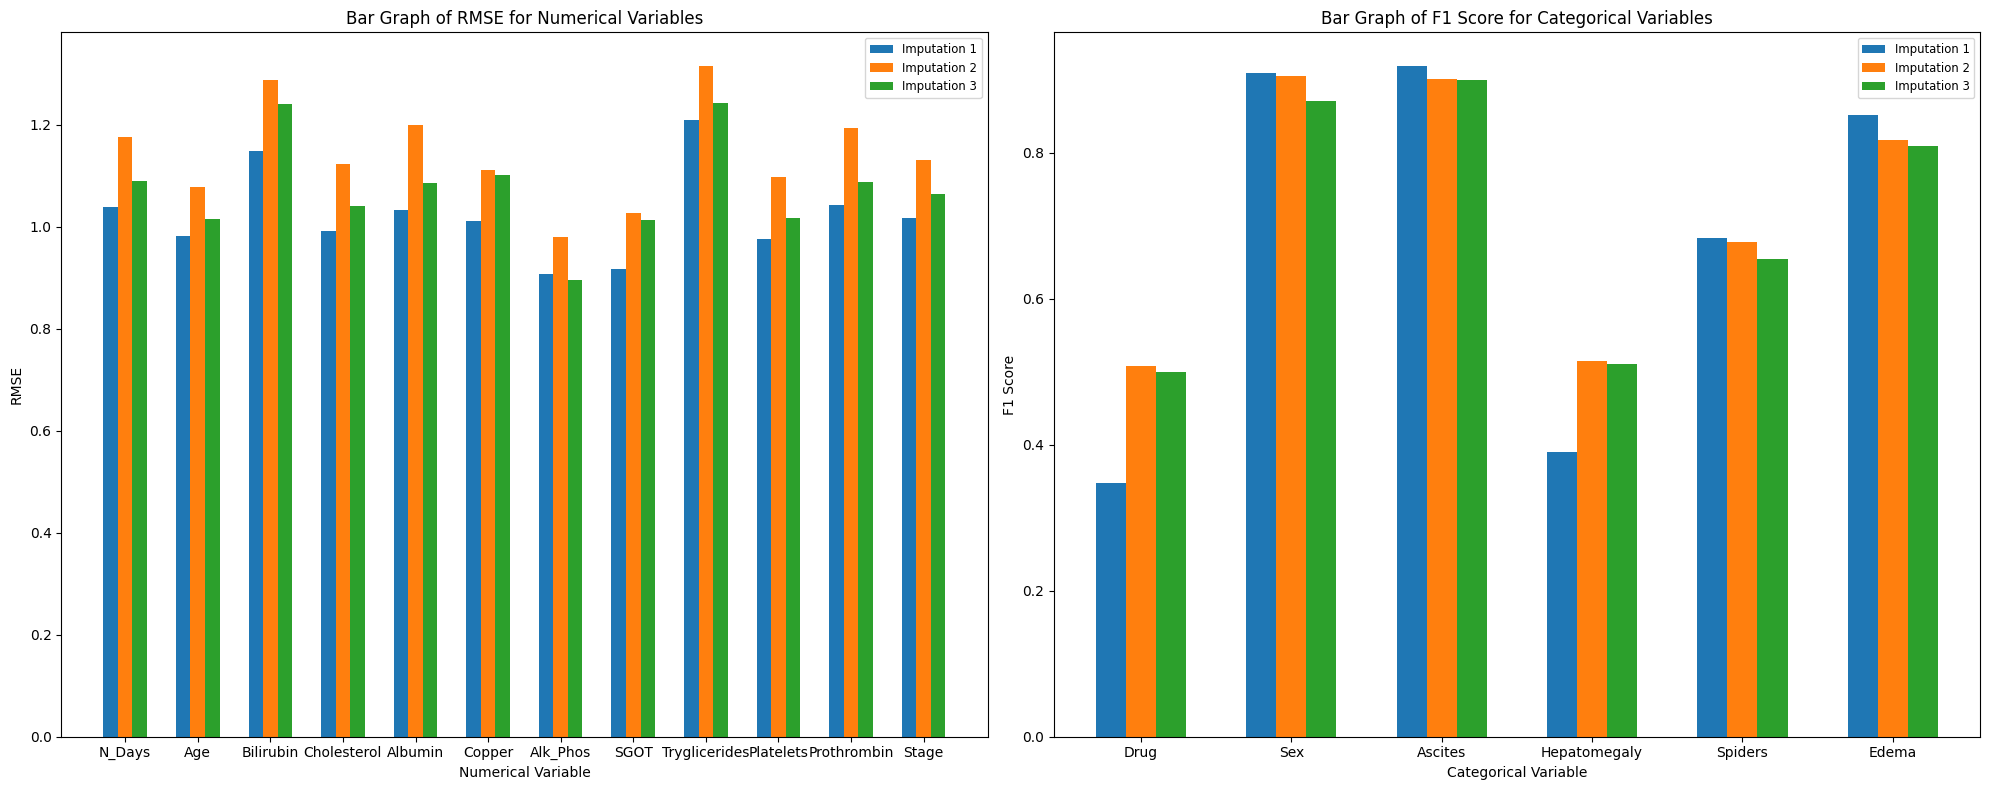

In [118]:
# define stores for the rmse and f1 of each method
rmse_store = [list(calc_num_metrics(actual_entries_X, imputed_entries_store, num_cols)['RMSE']) for imputed_entries_store in [imputed1_entries_store, imputed2_entries_store, imputed3_entries_store]]
f1_store = [list(calc_categorical_metrics(actual_entries_X, imputed_entries_store, categorical_cols)['F1 Score']) for imputed_entries_store in [imputed1_entries_store, imputed2_entries_store, imputed3_entries_store]]

# create subplots to plot both metrics and compare for each method
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# plot the bars for the numerical variables
for i in range(len(rmse_store)):
    axs[0].bar([x + i * 0.2 for x in list(range(len(rmse_store[0])))], rmse_store[i], 0.2, label=f'Imputation {i+1}')

# add labels and title for the numerical variables
axs[0].set_xlabel('Numerical Variable')
axs[0].set_ylabel('RMSE')
axs[0].set_title('Bar Graph of RMSE for Numerical Variables')
axs[0].set_xticks([x + 0.2 for x in list(range(len(rmse_store[0])))])
axs[0].set_xticklabels(num_cols)
axs[0].legend(fontsize='smaller')

# plot the bars for the categorical variables
for i in range(len(f1_store)):
    axs[1].bar([x + i * 0.2 for x in list(range(len(f1_store[0])))], f1_store[i], 0.2, label=f'Imputation {i+1}')

# add labels and title for the categorical variables
axs[1].set_xlabel('Categorical Variable')
axs[1].set_ylabel('F1 Score')
axs[1].set_title('Bar Graph of F1 Score for Categorical Variables')
axs[1].set_xticks([x + 0.2 for x in list(range(len(f1_store[0])))])
axs[1].set_xticklabels(categorical_cols)
axs[1].legend(fontsize='smaller')

# improve layout and plot
plt.tight_layout()
plt.show()

## Pipeline

The pipeline will handle:
- Data Cleaning
- Feature Engineering
- Unbalanced Data
- Scaling/Normalization
- Imputation Placeholder

HAS NOT BEEN RUN YET WILL PROB ERROR IF YOU RUN THE WHOLE DOCUMENT BECUSE ITS MISSING THE IMPUTATION AND OTHER THINGS

In [119]:
# Imports for pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer  # Placeholder for imputation
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline
from imblearn.under_sampling import RandomUnderSampler

##### Functions for the Pipeline

In [120]:
# Function for cleaning data
def clean_and_prep(data):
    """
    Cleans the dataset by applying imputation methods and handling outliers.

    Parameters:
    - data: pandas DataFrame containing the data to be cleaned.

    Returns:
    - The cleaned pandas DataFrame.
    """
    # IMPUTATION METHOD HERE
    
    # handle outliers:
    high = np.percentile(data["Bilirubin"], 95)  # 95th percentile
    data["Bilirubin"] = np.where(data["Bilirubin"] > high, high, data["Bilirubin"])

    high_copper = np.percentile(data["Copper"], 95)  # 95th percentile
    data["Copper"] = np.where(data["Copper"] > high_copper, high_copper, data["Copper"])

    # print(data.columns)
    data_tn = transform_numerical(data)

    data_tc = transform_categorical(data_tn)

    return data_tc


# Function for transforming numerical features
def transform_numerical(data):
    """
    Applies transformations to numerical features to address skewness and improve
    interpretability.

    Parameters:
    - data: pandas DataFrame with the numerical features to be transformed.

    Returns:
    - The DataFrame with transformed numerical features.
    """
    # print(data.columns)

    # Log transformation to address skewness
    data["Bilirubin"] = np.log(data["Bilirubin"] + 1).astype(float)
    data["Copper"] = np.log(data["Copper"] + 1).astype(float)
    data["Alk_Phos"] = np.log(data["Alk_Phos"] + 1).astype(float)
    data["SGOT"] = np.log(data["SGOT"] + 1).astype(float)

    # Normalize Age to be in years for better interpretability
    data["Age_in_Years"] = (data["Age"] / 365.25).astype(float)

    # Add other numerical transformations here
    return data.drop("Age", axis=1)


# Function for transforming categorical features
def transform_categorical(data):
    """
    Transforms categorical features into numerical format suitable for machine
    learning models.

    Parameters:
    - data: pandas DataFrame with the categorical features to be transformed.

    Returns:
    - The DataFrame with transformed categorical features.
    """
    data["Is_Male"] = (data["Sex"] == "M").astype(float)
    
    # Add other categorical transformations here if needed
    return data.drop("Sex", axis=1)

#### Defining Variables

In [121]:
# Preprocess data
train_data_prep = clean_and_prep(raw_training_data)
test_data_prep = clean_and_prep(raw_test_data)

# Define the columns to keep
columns_to_keep = [
    "N_Days", "Age_in_Years", "Is_Male", "Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
    "Stage", "Drug", "Ascites", "Hepatomegaly", "Spiders", 
    "Edema",
]
target_attribute = ["Status"]

train_data_prep_col = train_data_prep[columns_to_keep + target_attribute]
test_data_prep_col = test_data_prep[columns_to_keep]

# Numerical and categorical features
numerical_features = [
    "N_Days", "Age_in_Years","Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", 
    "Prothrombin", "Stage",
]

# Updated categorical features list after transformations
categorical_features = [ "Drug", "Ascites", "Hepatomegaly", 
                        "Spiders", "Edema",
    # 'Sex' has been transformed to 'Is_Male', which is now a numerical feature]
]




##### Pipeline

In [122]:
# Define the ColumnTransformer to handle numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numerical_features),
        ("categorical", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
    ]
)

# Define the sampling pipeline with SMOTE only 
smote_pipeline = imblearnPipeline(steps=[
    ("smote", SMOTE(random_state=42)),  # SMOTE for oversampling
   
])

# Define the full pipeline including preprocessing, SMOTE, and model fitting
full_pipeline_train_smote = imblearnPipeline(steps=[
    ("preprocessor", preprocessor),  # Preprocessing step
    ("sampling", smote_pipeline),  # Sampling step with SMOTE only
    # Add your model fitting step here, e.g., ("model", YourModelHere())
])

# Define the sampling pipeline with Random Undersampling only
undersample_pipeline = imblearnPipeline(steps=[
    ("undersample", RandomUnderSampler(random_state=42)),  # Random Undersampling
   
])

# Define the full pipeline including preprocessing, Random Undersampling, and model fitting
full_pipeline_train_undersample = imblearnPipeline(steps=[
    ("preprocessor", preprocessor),  # Preprocessing step
    ("sampling", undersample_pipeline),  # Sampling step with Random Undersampling only
    # Add your model fitting step here, e.g., ("model", YourModelHere())
])

# Define the test pipeline for preprocessing only
full_pipeline_test = imblearnPipeline(steps=[
     ("preprocessor", preprocessor),
])

# Split the training data into features (X_train) and target (y_train)
X_train = raw_training_data.drop(columns=['Status'])
y_train = raw_training_data['Status']

# Same for Test Data
X_test = raw_test_data

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Split the encoded target variable along with features into training and validation sets
X_train_encoded, X_val_encoded, y_train_encoded, y_val_encoded = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42)

# Fit and transform the training data using the pipeline with SMOTE
X_train_resampled_smote, y_train_resampled_smote = full_pipeline_train_smote.fit_resample(X_train_encoded, y_train_encoded)

# Fit and transform the training data using the pipeline with Random Undersampling
X_train_resampled_undersample, y_train_resampled_undersample = full_pipeline_train_undersample.fit_resample(X_train_encoded, y_train_encoded)



# Transform the test data with the test pipeline (not including sampling)
prepared_test_data = full_pipeline_test.transform(X_test)

## Model Training and Validation

Splitting prepared training data into training and validation sets

In [123]:
# # make sure to split the training data here 80/20 for training 
# # and validation (use  shuffle)

# # Separate features and target variable from the training data
# X = prepared_training_data.drop(['Status'], axis=1)
# y = prepared_training_data['Status']

# # Splitting data into training(80%) and validation(20%) sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0, stratify=y_train)

# # the quantity in training and validation set 
# print("Number of training sets:", len(X_train), "Number of validation sets:", len(X_val))
# print("Number of training target:", len(y_train), "Number of validation target:", len(y_val))

#has to be refactored becasue the pipeline needed the split beforehand for it to run w/o errors

# Split the resampled training data into training and validation sets (80/20 split) for SMOTE
X_train_final_smote, X_val_smote, y_train_final_smote, y_val_smote = train_test_split(
    X_train_resampled_smote, y_train_resampled_smote, test_size=0.2, random_state=42
)
# the quantity in training and validation set for SMOTE
print("Number of training sets for SMOTE:", len(X_train_final_smote), "Number of validation sets for SMOTE:", len(X_val_smote))
print("Number of training target for SMOTE:", len(y_train_final_smote), "Number of validation target for SMOTE:", len(y_val_smote))

# Split the resampled training data into training and validation sets (80/20 split) for Random Undersampling
X_train_final_undersample, X_val_undersample, y_train_final_undersample, y_val_undersample = train_test_split(
    X_train_resampled_undersample, y_train_resampled_undersample, test_size=0.2, random_state=42
)
# the quantity in training and validation set for Random Undersampling
print("Number of training sets for Random Undersampling:", len(X_train_final_undersample), "Number of validation sets for Random Undersampling:", len(X_val_undersample))
print("Number of training target for Random Undersampling:", len(y_train_final_undersample), "Number of validation target for Random Undersampling:", len(y_val_undersample))


Number of training sets for SMOTE: 9597 Number of validation sets for SMOTE: 2400
Number of training target for SMOTE: 9597 Number of validation target for SMOTE: 2400
Number of training sets for Random Undersampling: 535 Number of validation sets for Random Undersampling: 134
Number of training target for Random Undersampling: 535 Number of validation target for Random Undersampling: 134


In [124]:
import pandas as pd

# "status" Proportion in resampled training set (SMOTE)
print("Proportion in resampled training set for SMOTE:")
print(pd.Series(y_train_resampled_smote).value_counts() / len(y_train_resampled_smote))

# "status" Proportion in resampled training set (Random Undersampling)
print("Proportion in resampled training set for Random Undersampling:")
print(pd.Series(y_train_resampled_undersample).value_counts() / len(y_train_resampled_undersample))


Proportion in resampled training set for SMOTE:
1    0.333333
0    0.333333
2    0.333333
Name: count, dtype: float64
Proportion in resampled training set for Random Undersampling:
0    0.333333
1    0.333333
2    0.333333
Name: count, dtype: float64


In [125]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

Fit Models

In [126]:
# SVM model and enable probability estimation for logloss calculation (for SMOTE)
svm_clf_smote = SVC(probability=True)  # Running time is relatively long
# RandomForest model (for SMOTE)
random_forest_clf_smote = RandomForestClassifier()
# LogisticRegression model (for SMOTE)
logistic_reg_clf_smote = LogisticRegression()

# Training models (for SMOTE)
svm_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)
random_forest_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)
logistic_reg_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)

# SVM model and enable probability estimation for logloss calculation (for Random Undersampling)
svm_clf_undersample = SVC(probability=True)  # Running time is relatively long
# RandomForest model (for Random Undersampling)
random_forest_clf_undersample = RandomForestClassifier()
# LogisticRegression model (for Random Undersampling)
logistic_reg_clf_undersample = LogisticRegression()

# Training models (for Random Undersampling)
svm_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)
random_forest_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)
logistic_reg_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)


XGBclassifier Model

In [ ]:
# When XGBClassifier ​​processes target variables, it expects these variables to be numeric.
# ??? Consider whether to use this model and add labeling the target variable y to the pipeline
le=LabelEncoder()
# Label encode the target variable for SMOTE training set
y_train_resampled_smote_label = le.fit_transform(y_train_resampled_smote)
# Label encode the target variable for Random Undersampling training set
y_train_resampled_undersample_label = le.fit_transform(y_train_resampled_undersample)

# XGBClassifier model for SMOTE
XGB_clf_smote = XGBClassifier()
# XGBClassifier model for Random Undersampling
XGB_clf_undersample = XGBClassifier()

# Training models
XGB_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote_label) 
XGB_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample_label) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Evaluate model performance

In [ ]:
# Transform the validation data using the preprocessor in the pipeline
X_val_preprocessed = full_pipeline_test.transform(X_val_encoded)

# Predict probabilities for validation set using models trained on SMOTE-augmented data
y_val_proba_svm_smote = svm_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_rf_smote = random_forest_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_LR_smote = logistic_reg_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_XGB_smote = XGB_clf_smote.predict_proba(X_val_preprocessed)

# Calculate log loss for each model on validation set
logloss_val_svm_smote = log_loss(y_val_encoded, y_val_proba_svm_smote)
loss_val_rf_smote = log_loss(y_val_encoded, y_pred_proba_rf_smote)
loss_val_LR_smote = log_loss(y_val_encoded, y_pred_proba_LR_smote)
loss_val_XGB_smote = log_loss(y_val_encoded, y_pred_proba_XGB_smote)

# Print log loss values for each model
print(f"SVM model Validation set Log Loss: {logloss_val_svm_smote}")
print(f"Random forest model Validation set Log Loss: {loss_val_rf_smote}")
print(f"Logistic regression model Validation set Log Loss: {loss_val_LR_smote}")
print(f"XGBoost model Validation set Log Loss: {loss_val_XGB_smote}")


SVM model Validation set Log Loss: 0.5834592525179333
Random forest model Validation set Log Loss: 0.4989205866234703
Logistic regression model Validation set Log Loss: 0.7460301454733721
XGBoost model Validation set Log Loss: 0.5152148070152034


In [ ]:
# Predict validation set data for 'Status' (SMOTE)
y_pred_SVM_smote = svm_clf_smote.predict(X_val_smote)
y_pred_random_forest_smote = random_forest_clf_smote.predict(X_val_smote)
y_pred_logistic_reg_smote = logistic_reg_clf_smote.predict(X_val_smote)
y_pred_XGB_smote = XGB_clf_smote.predict(X_val_smote)


# precision, recall, f1-score, accuracy (SMOTE)
report_SVM_smote = classification_report(y_val_smote, y_pred_SVM_smote, zero_division=0)
report_random_forest_smote = classification_report(y_val_smote, y_pred_random_forest_smote, zero_division=0)
report_logistic_regression_smote = classification_report(y_val_smote, y_pred_logistic_reg_smote, zero_division=0)
report_XGB_smote = classification_report(y_val_smote, y_pred_XGB_smote, zero_division=0) 

print("For SMOTE:")
print(f"SVM: {report_SVM_smote}")
print(f"Random forest: {report_random_forest_smote}")
print(f"Logistic regression: {report_logistic_regression_smote}")
print(f"XGB: {report_XGB_smote}")


For SMOTE:
SVM:               precision    recall  f1-score   support

           0       0.82      0.80      0.81       803
           1       0.86      0.94      0.90       802
           2       0.87      0.79      0.83       795

    accuracy                           0.85      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.85      0.85      0.85      2400

Random forest:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       803
           1       1.00      1.00      1.00       802
           2       1.00      1.00      1.00       795

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Logistic regression:               precision    recall  f1-score   support

           0       0.66      0.70      0.68       803
           1       0.63      0.65      0.64       802
           2       0.69

In [ ]:
# Predict validation set data for 'Status' (Random Undersampling)
y_pred_SVM_undersample = svm_clf_undersample.predict(X_val_undersample)
y_pred_random_forest_undersample = random_forest_clf_undersample.predict(X_val_undersample)
y_pred_logistic_reg_undersample = logistic_reg_clf_undersample.predict(X_val_undersample)
y_pred_XGB_undersample = XGB_clf_undersample.predict(X_val_undersample)

# precision, recall, f1-score, accuracy (Random Undersampling)
report_SVM_undersample = classification_report(y_val_undersample, y_pred_SVM_undersample, zero_division=0)
report_random_forest_undersample = classification_report(y_val_undersample, y_pred_random_forest_undersample, zero_division=0)
report_logistic_regression_undersample = classification_report(y_val_undersample, y_pred_logistic_reg_undersample, zero_division=0)
report_XGB_undersample = classification_report(y_val_undersample, y_pred_XGB_undersample, zero_division=0) 

print("For Random Undersampling:")
print(f"SVM: {report_SVM_undersample}")
print(f"Random forest: {report_random_forest_undersample}")
print(f"Logistic regression: {report_logistic_regression_undersample}")
print(f"XGB: {report_XGB_undersample}")


For Random Undersampling:
SVM:               precision    recall  f1-score   support

           0       0.81      0.82      0.81        56
           1       0.52      0.71      0.60        31
           2       0.89      0.66      0.76        47

    accuracy                           0.74       134
   macro avg       0.74      0.73      0.72       134
weighted avg       0.77      0.74      0.74       134

Random forest:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        47

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

Logistic regression:               precision    recall  f1-score   support

           0       0.75      0.70      0.72        56
           1       0.37      0.52      0.43        31
        

In [ ]:
# # Cross-validation for SMOTE
# scores_SVM_smote = cross_val_score(svm_clf_smote, X_train_final_smote, y_train_final_smote, cv=3, scoring="accuracy")
# print(scores_SVM_smote)

# scores_random_forest_smote = cross_val_score(random_forest_clf_smote, X_train_final_smote, y_train_final_smote, cv=3, scoring="accuracy")
# print(scores_random_forest_smote)

# scores_logistic_reg_smote = cross_val_score(logistic_reg_clf_smote, X_train_final_smote, y_train_final_smote, cv=3, scoring="accuracy")
# print(scores_logistic_reg_smote)

# scores_XGB_smote = cross_val_score(XGB_clf_smote, X_train_final_smote, y_train_final_smote, cv=3, scoring="accuracy")
# print(scores_XGB_smote)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define a custom scorer for log loss
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Define the models
models = {
    "SVM": svm_clf_smote,
    "Random Forest": random_forest_clf_smote,
    "Logistic Regression": logistic_reg_clf_smote,
    "XGBoost": XGB_clf_smote
}

# Perform cross-validation for each model
for name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_resampled_smote, y_train_resampled_smote, 
                                cv=5, scoring=log_loss_scorer)
    
    # Calculate mean and standard deviation of cross-validation scores
    mean_score = -cv_scores.mean()  # Taking negative as we used greater_is_better=False
    std_score = cv_scores.std()
    
    # Print the results
    print(f"{name} Cross-Validation Log Loss: {mean_score:.4f} (+/- {2 * std_score:.4f})")


SVM Cross-Validation Log Loss: 0.4554 (+/- 0.0308)
Random Forest Cross-Validation Log Loss: 0.3373 (+/- 0.0467)
Logistic Regression Cross-Validation Log Loss: 0.7773 (+/- 0.0409)
XGBoost Cross-Validation Log Loss: 0.2746 (+/- 0.1109)


In [ ]:

def plot_confusion_matrices(matrix_svm, matrix_rf, matrix_lr, matrix_xgb, title_suffix):
    """
    Plot confusion matrices for multiple classifiers.

    Parameters:
        matrix_svm (array-like): Confusion matrix for SVM classifier.
        matrix_rf (array-like): Confusion matrix for Random Forest classifier.
        matrix_lr (array-like): Confusion matrix for Logistic Regression classifier.
        title_suffix (str): Suffix to be added to the title of each confusion matrix plot.

    Returns:
        None
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8)) 

    # SVM
    sns.heatmap(matrix_svm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[0,0])
    axes[0,0].set_title(f'SVM Confusion Matrix ({title_suffix})')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')

    # Random Forest
    sns.heatmap(matrix_rf, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[0,1])
    axes[0,1].set_title(f'Random Forest Confusion Matrix ({title_suffix})')
    axes[0,1].set_xlabel('Predicted Label')
    axes[0,1].set_ylabel('True Label')

    # Logistic Regression
    sns.heatmap(matrix_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[1,0])
    axes[1,0].set_title(f'Logistic Regression Confusion Matrix ({title_suffix})')
    axes[1,0].set_xlabel('Predicted Label')
    axes[1,0].set_ylabel('True Label')

    # XGBoost
    sns.heatmap(matrix_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[1,1])
    axes[1,1].set_title(f'XGBoost Confusion Matrix ({title_suffix})')
    axes[1,1].set_xlabel('Predicted Label')
    axes[1,1].set_ylabel('True Label')



    plt.tight_layout() 
    plt.show()


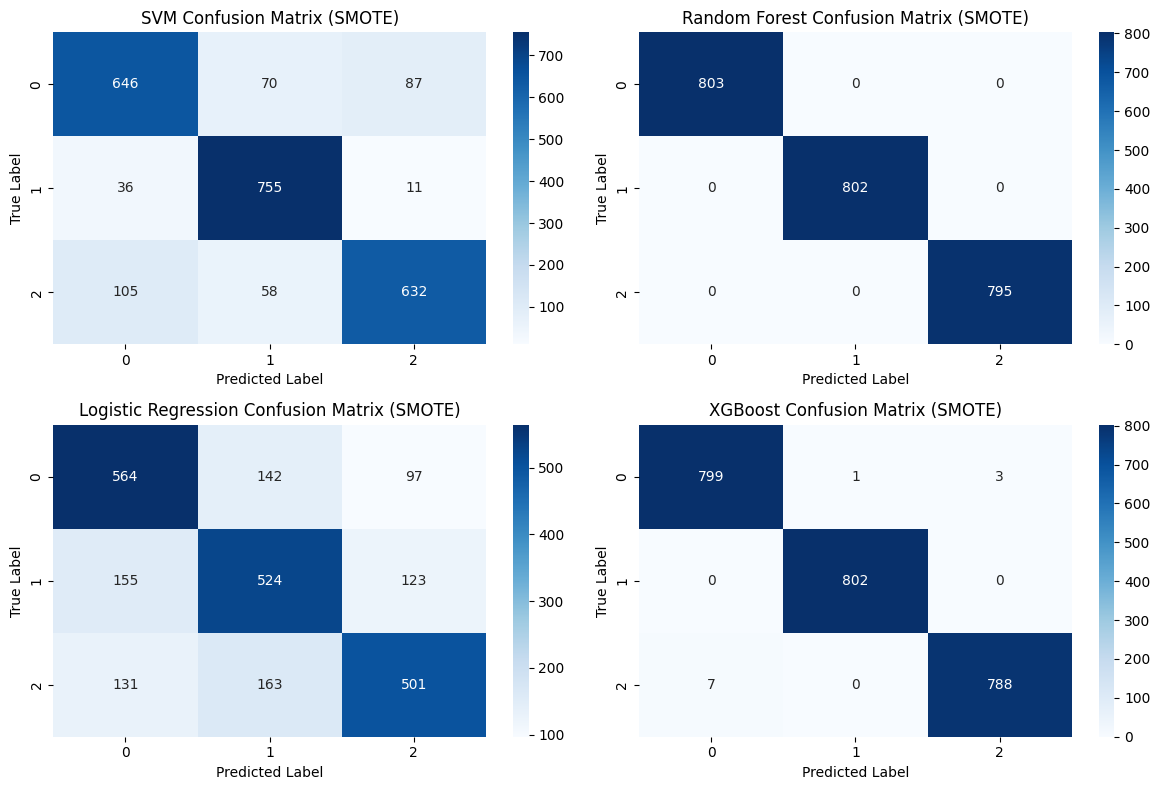

In [ ]:
# Calculate the confusion matrix on the valid data for SMOTE
matrix_val_tree_svm_smote = confusion_matrix(y_val_smote, y_pred_SVM_smote)
matrix_val_tree_rf_smote = confusion_matrix(y_val_smote, y_pred_random_forest_smote)
matrix_val_tree_lr_smote = confusion_matrix(y_val_smote, y_pred_logistic_reg_smote)
matrix_val_tree_XGB_smote = confusion_matrix(y_val_smote, y_pred_XGB_smote)

plot_confusion_matrices(matrix_val_tree_svm_smote, matrix_val_tree_rf_smote, matrix_val_tree_lr_smote, matrix_val_tree_XGB_smote ,"SMOTE")


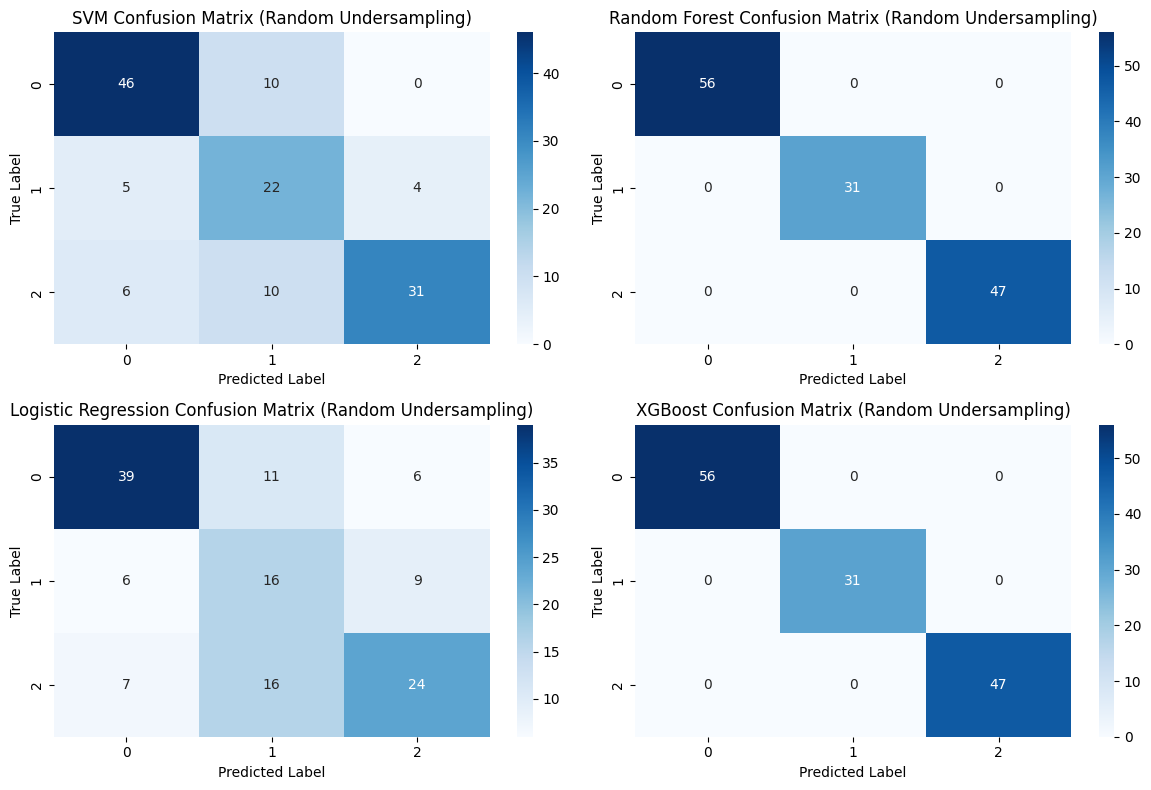

In [ ]:
# Calculate the confusion matrix on the valid data for Random Undersampling
matrix_val_tree_svm_undersample = confusion_matrix(y_val_undersample, y_pred_SVM_undersample)
matrix_val_tree_rf_undersample = confusion_matrix(y_val_undersample, y_pred_random_forest_undersample)
matrix_val_tree_lr_undersample = confusion_matrix(y_val_undersample, y_pred_logistic_reg_undersample)
matrix_val_tree_XGB_undersample = confusion_matrix(y_val_undersample, y_pred_XGB_undersample)

plot_confusion_matrices(matrix_val_tree_svm_undersample, matrix_val_tree_rf_undersample, matrix_val_tree_lr_undersample,matrix_val_tree_XGB_undersample, "Random Undersampling")


## Testing

## Hyperparameter Optimization

In [ ]:
import optuna


# Define a custom scorer for Optuna optimization
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    return log_loss(y, y_pred)

# Optimize hyperparameters using Optuna for the ensemble of RandomForest and XGBoost
def optimize_hyperparameters_ensemble(X_train, y_train):
    def objective(trial):
        rf_params = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('rf_max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
            'max_features': trial.suggest_uniform('rf_max_features', 0.1, 1.0),
            'random_state': 42,
            'n_jobs': -1
        }
        
        xgb_params = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 1000),
            'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.001, 0.1),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
            'subsample': trial.suggest_uniform('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('xgb_colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_loguniform('xgb_gamma', 1e-8, 1.0),
            'reg_alpha': trial.suggest_loguniform('xgb_reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_loguniform('xgb_reg_lambda', 1e-8, 1.0),
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'num_class': len(np.unique(y_train)),
            'use_label_encoder': False,  # For XGBoost 1.3.0 and later
            'tree_method': 'hist',
            'verbosity': 0
        }
        
        # Initialize RandomForest and XGBoost models with suggested parameters
        rf_model = RandomForestClassifier(**rf_params)
        xgb_model = XGBClassifier(**xgb_params)
        
        # Fit RandomForest and XGBoost models
        rf_model.fit(X_train, y_train)
        xgb_model.fit(X_train, y_train)
        
        # Ensemble the RandomForest and XGBoost models
        ensemble_proba = (rf_model.predict_proba(X_train) + xgb_model.predict_proba(X_train)) / 2
        
        # Calculate log loss for the ensemble on the training set
        ensemble_log_loss = log_loss(y_train, ensemble_proba)

        # Print ensemble log loss for each trial
        print(f"Ensemble Log Loss for trial {trial.number}: {ensemble_log_loss}")
        
        return ensemble_log_loss

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    
    best_params = study.best_params
    return best_params

# Optimize hyperparameters for the ensemble of RandomForest and XGBoost
best_params_ensemble = optimize_hyperparameters_ensemble(X_train_resampled_smote, y_train_resampled_smote)
print("Best hyperparameters for Ensemble (RandomForest + XGBoost):", best_params_ensemble)


[I 2024-03-28 16:59:13,296] A new study created in memory with name: no-name-ca416cf5-3857-40f7-a87f-6e369c5a87eb
[I 2024-03-28 16:59:18,538] Trial 0 finished with value: 0.42337118592700274 and parameters: {'rf_n_estimators': 847, 'rf_max_depth': 9, 'rf_min_samples_split': 18, 'rf_min_samples_leaf': 7, 'rf_max_features': 0.855284883888309, 'xgb_n_estimators': 170, 'xgb_learning_rate': 0.041534955709978366, 'xgb_max_depth': 4, 'xgb_subsample': 0.7794910806957207, 'xgb_colsample_bytree': 0.789672195184967, 'xgb_gamma': 0.053773798354613066, 'xgb_reg_alpha': 1.4844774270554636e-08, 'xgb_reg_lambda': 2.9718383435184766e-05}. Best is trial 0 with value: 0.42337118592700274.


Ensemble Log Loss for trial 0: 0.42337118592700274


[I 2024-03-28 16:59:24,028] Trial 1 finished with value: 0.6866019415727144 and parameters: {'rf_n_estimators': 448, 'rf_max_depth': 7, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.6547592934799825, 'xgb_n_estimators': 211, 'xgb_learning_rate': 0.0011124529390190373, 'xgb_max_depth': 9, 'xgb_subsample': 0.6797278674725177, 'xgb_colsample_bytree': 0.6370119544417192, 'xgb_gamma': 0.04043203223137372, 'xgb_reg_alpha': 1.102295140600815e-08, 'xgb_reg_lambda': 1.0059185145439182e-06}. Best is trial 0 with value: 0.42337118592700274.


Ensemble Log Loss for trial 1: 0.6866019415727144


[I 2024-03-28 16:59:25,922] Trial 2 finished with value: 0.779912257715257 and parameters: {'rf_n_estimators': 179, 'rf_max_depth': 3, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.5589172939943615, 'xgb_n_estimators': 808, 'xgb_learning_rate': 0.001571931713419956, 'xgb_max_depth': 3, 'xgb_subsample': 0.6552730031521554, 'xgb_colsample_bytree': 0.8516748509492327, 'xgb_gamma': 1.2565704580546424e-08, 'xgb_reg_alpha': 0.007584892326066817, 'xgb_reg_lambda': 6.988860375359105e-07}. Best is trial 0 with value: 0.42337118592700274.


Ensemble Log Loss for trial 2: 0.779912257715257


[I 2024-03-28 16:59:28,088] Trial 3 finished with value: 0.3725132898866373 and parameters: {'rf_n_estimators': 343, 'rf_max_depth': 9, 'rf_min_samples_split': 18, 'rf_min_samples_leaf': 6, 'rf_max_features': 0.7511701745732285, 'xgb_n_estimators': 89, 'xgb_learning_rate': 0.08948769903832059, 'xgb_max_depth': 5, 'xgb_subsample': 0.8290887663135669, 'xgb_colsample_bytree': 0.6206805039607298, 'xgb_gamma': 0.0024225632911933845, 'xgb_reg_alpha': 3.2663270798583023e-07, 'xgb_reg_lambda': 1.5635599034120077e-05}. Best is trial 3 with value: 0.3725132898866373.


Ensemble Log Loss for trial 3: 0.3725132898866373


[I 2024-03-28 16:59:50,417] Trial 4 finished with value: 0.3694726205155702 and parameters: {'rf_n_estimators': 51, 'rf_max_depth': 7, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.3966022999706392, 'xgb_n_estimators': 956, 'xgb_learning_rate': 0.0033031319890660816, 'xgb_max_depth': 9, 'xgb_subsample': 0.7888220038438708, 'xgb_colsample_bytree': 0.8163710925895995, 'xgb_gamma': 3.504020103735017e-07, 'xgb_reg_alpha': 1.9197789116581584e-05, 'xgb_reg_lambda': 0.3479163074964221}. Best is trial 4 with value: 0.3694726205155702.


Ensemble Log Loss for trial 4: 0.3694726205155702


[I 2024-03-28 16:59:56,065] Trial 5 finished with value: 0.5699106699264667 and parameters: {'rf_n_estimators': 792, 'rf_max_depth': 9, 'rf_min_samples_split': 18, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.8104798430853222, 'xgb_n_estimators': 456, 'xgb_learning_rate': 0.001993726498701392, 'xgb_max_depth': 5, 'xgb_subsample': 0.6373183710621388, 'xgb_colsample_bytree': 0.6919510709521665, 'xgb_gamma': 7.528423046821118e-07, 'xgb_reg_alpha': 9.41968760702073e-05, 'xgb_reg_lambda': 2.7529940719207907e-07}. Best is trial 4 with value: 0.3694726205155702.


Ensemble Log Loss for trial 5: 0.5699106699264667


[I 2024-03-28 17:00:03,942] Trial 6 finished with value: 0.37075360862716006 and parameters: {'rf_n_estimators': 634, 'rf_max_depth': 10, 'rf_min_samples_split': 13, 'rf_min_samples_leaf': 6, 'rf_max_features': 0.17216181872080907, 'xgb_n_estimators': 754, 'xgb_learning_rate': 0.004347781967723997, 'xgb_max_depth': 8, 'xgb_subsample': 0.7238657174914654, 'xgb_colsample_bytree': 0.638568882265643, 'xgb_gamma': 0.0025345360025638836, 'xgb_reg_alpha': 0.10555071534231038, 'xgb_reg_lambda': 4.817252682045428e-07}. Best is trial 4 with value: 0.3694726205155702.


Ensemble Log Loss for trial 6: 0.37075360862716006


[I 2024-03-28 17:00:06,609] Trial 7 finished with value: 0.5129106652570173 and parameters: {'rf_n_estimators': 238, 'rf_max_depth': 7, 'rf_min_samples_split': 17, 'rf_min_samples_leaf': 9, 'rf_max_features': 0.5502893799603846, 'xgb_n_estimators': 263, 'xgb_learning_rate': 0.006789692664468557, 'xgb_max_depth': 7, 'xgb_subsample': 0.7737524738342871, 'xgb_colsample_bytree': 0.8844356125025752, 'xgb_gamma': 1.9187622672942217e-08, 'xgb_reg_alpha': 1.3128683618838314e-05, 'xgb_reg_lambda': 0.17446341986908592}. Best is trial 4 with value: 0.3694726205155702.


Ensemble Log Loss for trial 7: 0.5129106652570173


[I 2024-03-28 17:00:12,830] Trial 8 finished with value: 0.5046045145225976 and parameters: {'rf_n_estimators': 744, 'rf_max_depth': 3, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 2, 'rf_max_features': 0.3503000060459782, 'xgb_n_estimators': 146, 'xgb_learning_rate': 0.0132924701484216, 'xgb_max_depth': 10, 'xgb_subsample': 0.7468905040060622, 'xgb_colsample_bytree': 0.908826810247639, 'xgb_gamma': 4.583152667661367e-07, 'xgb_reg_alpha': 3.2082714591068305e-06, 'xgb_reg_lambda': 7.893039877376827e-08}. Best is trial 4 with value: 0.3694726205155702.


Ensemble Log Loss for trial 8: 0.5046045145225976


[I 2024-03-28 17:00:15,133] Trial 9 finished with value: 0.3027602505154992 and parameters: {'rf_n_estimators': 210, 'rf_max_depth': 4, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 9, 'rf_max_features': 0.5282497365987822, 'xgb_n_estimators': 987, 'xgb_learning_rate': 0.07471925859712836, 'xgb_max_depth': 7, 'xgb_subsample': 0.9852047559817523, 'xgb_colsample_bytree': 0.7669510366102609, 'xgb_gamma': 0.12022329038958426, 'xgb_reg_alpha': 4.873951981229629e-07, 'xgb_reg_lambda': 0.022807277136803365}. Best is trial 9 with value: 0.3027602505154992.


Ensemble Log Loss for trial 9: 0.3027602505154992


[I 2024-03-28 17:00:18,189] Trial 10 finished with value: 0.4056982961823476 and parameters: {'rf_n_estimators': 525, 'rf_max_depth': 5, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 10, 'rf_max_features': 0.34730993544588085, 'xgb_n_estimators': 564, 'xgb_learning_rate': 0.017899617401139, 'xgb_max_depth': 6, 'xgb_subsample': 0.9827913090877413, 'xgb_colsample_bytree': 0.984639076683917, 'xgb_gamma': 0.47480563128894937, 'xgb_reg_alpha': 0.0020257785826558175, 'xgb_reg_lambda': 0.004412731659420551}. Best is trial 9 with value: 0.3027602505154992.


Ensemble Log Loss for trial 10: 0.4056982961823476


[I 2024-03-28 17:00:28,993] Trial 11 finished with value: 0.436270947643295 and parameters: {'rf_n_estimators': 71, 'rf_max_depth': 5, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 8, 'rf_max_features': 0.3831124239138046, 'xgb_n_estimators': 983, 'xgb_learning_rate': 0.003767652008920602, 'xgb_max_depth': 8, 'xgb_subsample': 0.8854735225842569, 'xgb_colsample_bytree': 0.7627432898438775, 'xgb_gamma': 2.5149527512993718e-05, 'xgb_reg_alpha': 6.812211958161714e-07, 'xgb_reg_lambda': 0.8895084593009491}. Best is trial 9 with value: 0.3027602505154992.


Ensemble Log Loss for trial 11: 0.436270947643295


[I 2024-03-28 17:00:41,114] Trial 12 finished with value: 0.2934679042213418 and parameters: {'rf_n_estimators': 74, 'rf_max_depth': 5, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 2, 'rf_max_features': 0.1085332822769563, 'xgb_n_estimators': 925, 'xgb_learning_rate': 0.02927258729106317, 'xgb_max_depth': 10, 'xgb_subsample': 0.9648010302778972, 'xgb_colsample_bytree': 0.7429431444375267, 'xgb_gamma': 3.222859736660659e-05, 'xgb_reg_alpha': 0.00010898609297523377, 'xgb_reg_lambda': 0.006836867233941909}. Best is trial 12 with value: 0.2934679042213418.


Ensemble Log Loss for trial 12: 0.2934679042213418


[I 2024-03-28 17:00:51,813] Trial 13 finished with value: 0.2818700339947323 and parameters: {'rf_n_estimators': 998, 'rf_max_depth': 5, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 1, 'rf_max_features': 0.13232880291849813, 'xgb_n_estimators': 788, 'xgb_learning_rate': 0.03748351356489438, 'xgb_max_depth': 10, 'xgb_subsample': 0.9997343625443085, 'xgb_colsample_bytree': 0.7256917419844378, 'xgb_gamma': 5.4081125444992555e-05, 'xgb_reg_alpha': 0.0011036935678805952, 'xgb_reg_lambda': 0.01140275077931255}. Best is trial 13 with value: 0.2818700339947323.


Ensemble Log Loss for trial 13: 0.2818700339947323


[I 2024-03-28 17:01:01,688] Trial 14 finished with value: 0.2847539583342766 and parameters: {'rf_n_estimators': 993, 'rf_max_depth': 5, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 1, 'rf_max_features': 0.13169446147068112, 'xgb_n_estimators': 707, 'xgb_learning_rate': 0.029725648727153994, 'xgb_max_depth': 10, 'xgb_subsample': 0.9175106238741557, 'xgb_colsample_bytree': 0.7109394939347495, 'xgb_gamma': 4.170727497219277e-05, 'xgb_reg_alpha': 0.001331203051402115, 'xgb_reg_lambda': 0.0007934203786140718}. Best is trial 13 with value: 0.2818700339947323.


Ensemble Log Loss for trial 14: 0.2847539583342766


[I 2024-03-28 17:01:12,016] Trial 15 finished with value: 0.2618726143474533 and parameters: {'rf_n_estimators': 995, 'rf_max_depth': 6, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 1, 'rf_max_features': 0.22129857514502738, 'xgb_n_estimators': 627, 'xgb_learning_rate': 0.03254067053450218, 'xgb_max_depth': 10, 'xgb_subsample': 0.9123609941560812, 'xgb_colsample_bytree': 0.7038355206298138, 'xgb_gamma': 0.0004497601762636462, 'xgb_reg_alpha': 0.7412790875513577, 'xgb_reg_lambda': 0.0005192992461498082}. Best is trial 15 with value: 0.2618726143474533.


Ensemble Log Loss for trial 15: 0.2618726143474533


[I 2024-03-28 17:01:18,618] Trial 16 finished with value: 0.2681272635140026 and parameters: {'rf_n_estimators': 952, 'rf_max_depth': 6, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 1, 'rf_max_features': 0.21607143944021856, 'xgb_n_estimators': 581, 'xgb_learning_rate': 0.04901741753754216, 'xgb_max_depth': 9, 'xgb_subsample': 0.9071069005115926, 'xgb_colsample_bytree': 0.6933383680819081, 'xgb_gamma': 0.0005415442393191946, 'xgb_reg_alpha': 0.9536548787115858, 'xgb_reg_lambda': 0.0002719595093059454}. Best is trial 15 with value: 0.2618726143474533.


Ensemble Log Loss for trial 16: 0.2681272635140026


[I 2024-03-28 17:01:28,043] Trial 17 finished with value: 0.23725271777461113 and parameters: {'rf_n_estimators': 886, 'rf_max_depth': 6, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 3, 'rf_max_features': 0.9754182784795041, 'xgb_n_estimators': 523, 'xgb_learning_rate': 0.05618731228742266, 'xgb_max_depth': 9, 'xgb_subsample': 0.8628548104623578, 'xgb_colsample_bytree': 0.6806721636288292, 'xgb_gamma': 0.0007931348964988434, 'xgb_reg_alpha': 0.6221319345611678, 'xgb_reg_lambda': 0.0002076665576743085}. Best is trial 17 with value: 0.23725271777461113.


Ensemble Log Loss for trial 17: 0.23725271777461113


[I 2024-03-28 17:01:34,369] Trial 18 finished with value: 0.29586335597324953 and parameters: {'rf_n_estimators': 679, 'rf_max_depth': 8, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 3, 'rf_max_features': 0.7025514759311273, 'xgb_n_estimators': 371, 'xgb_learning_rate': 0.01847128799683505, 'xgb_max_depth': 8, 'xgb_subsample': 0.8394561937799021, 'xgb_colsample_bytree': 0.6654923296718751, 'xgb_gamma': 0.0005390337153917733, 'xgb_reg_alpha': 0.9545396671788028, 'xgb_reg_lambda': 8.616243452529085e-06}. Best is trial 17 with value: 0.23725271777461113.


Ensemble Log Loss for trial 18: 0.29586335597324953


[I 2024-03-28 17:01:42,807] Trial 19 finished with value: 0.22842657522894647 and parameters: {'rf_n_estimators': 872, 'rf_max_depth': 6, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 3, 'rf_max_features': 0.9970097378494118, 'xgb_n_estimators': 660, 'xgb_learning_rate': 0.061530736392220994, 'xgb_max_depth': 9, 'xgb_subsample': 0.8635314627386823, 'xgb_colsample_bytree': 0.6045364330712699, 'xgb_gamma': 4.369992790056438e-06, 'xgb_reg_alpha': 0.054870433745957785, 'xgb_reg_lambda': 1.1889116089262218e-08}. Best is trial 19 with value: 0.22842657522894647.


Ensemble Log Loss for trial 19: 0.22842657522894647


[I 2024-03-28 17:01:49,833] Trial 20 finished with value: 0.23582668378806682 and parameters: {'rf_n_estimators': 861, 'rf_max_depth': 8, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 3, 'rf_max_features': 0.9217860489717231, 'xgb_n_estimators': 460, 'xgb_learning_rate': 0.05583547131891888, 'xgb_max_depth': 6, 'xgb_subsample': 0.8566701452671908, 'xgb_colsample_bytree': 0.6140475583538801, 'xgb_gamma': 3.972673271848465e-06, 'xgb_reg_alpha': 0.06316786447217058, 'xgb_reg_lambda': 1.6335711569581802e-08}. Best is trial 19 with value: 0.22842657522894647.


Ensemble Log Loss for trial 20: 0.23582668378806682


[I 2024-03-28 17:01:56,462] Trial 21 finished with value: 0.24183552437150918 and parameters: {'rf_n_estimators': 893, 'rf_max_depth': 8, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 3, 'rf_max_features': 0.9820726521473429, 'xgb_n_estimators': 434, 'xgb_learning_rate': 0.0555553288053045, 'xgb_max_depth': 6, 'xgb_subsample': 0.8676776962680451, 'xgb_colsample_bytree': 0.6190020485082385, 'xgb_gamma': 3.887357397263373e-06, 'xgb_reg_alpha': 0.02902440361193952, 'xgb_reg_lambda': 1.3030826271944881e-08}. Best is trial 19 with value: 0.22842657522894647.


Ensemble Log Loss for trial 21: 0.24183552437150918


[I 2024-03-28 17:02:08,612] Trial 22 finished with value: 0.2145761302238634 and parameters: {'rf_n_estimators': 859, 'rf_max_depth': 8, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 3, 'rf_max_features': 0.9855118222688884, 'xgb_n_estimators': 324, 'xgb_learning_rate': 0.07235736926603852, 'xgb_max_depth': 7, 'xgb_subsample': 0.8392152809220056, 'xgb_colsample_bytree': 0.6076260610333646, 'xgb_gamma': 5.650010320773174e-06, 'xgb_reg_alpha': 0.0713679893059844, 'xgb_reg_lambda': 1.2281467221333209e-08}. Best is trial 22 with value: 0.2145761302238634.


Ensemble Log Loss for trial 22: 0.2145761302238634


[I 2024-03-28 17:02:15,134] Trial 23 finished with value: 0.26999141599745435 and parameters: {'rf_n_estimators': 674, 'rf_max_depth': 8, 'rf_min_samples_split': 15, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.9105335550908433, 'xgb_n_estimators': 288, 'xgb_learning_rate': 0.09850133726127855, 'xgb_max_depth': 5, 'xgb_subsample': 0.8238857710355373, 'xgb_colsample_bytree': 0.6548324452443157, 'xgb_gamma': 2.9971480605705063e-06, 'xgb_reg_alpha': 0.058181381657455795, 'xgb_reg_lambda': 1.6767954315846238e-08}. Best is trial 22 with value: 0.2145761302238634.


Ensemble Log Loss for trial 23: 0.26999141599745435


[I 2024-03-28 17:02:34,689] Trial 24 finished with value: 0.2674849769826187 and parameters: {'rf_n_estimators': 793, 'rf_max_depth': 10, 'rf_min_samples_split': 20, 'rf_min_samples_leaf': 2, 'rf_max_features': 0.9079722199929467, 'xgb_n_estimators': 365, 'xgb_learning_rate': 0.021305470658029093, 'xgb_max_depth': 7, 'xgb_subsample': 0.9403793039570958, 'xgb_colsample_bytree': 0.619434568686033, 'xgb_gamma': 8.887034492393248e-08, 'xgb_reg_alpha': 0.019132378036498913, 'xgb_reg_lambda': 5.850372613319892e-08}. Best is trial 22 with value: 0.2145761302238634.


Ensemble Log Loss for trial 24: 0.2674849769826187


[I 2024-03-28 17:02:41,303] Trial 25 finished with value: 0.20128664071849958 and parameters: {'rf_n_estimators': 590, 'rf_max_depth': 8, 'rf_min_samples_split': 14, 'rf_min_samples_leaf': 3, 'rf_max_features': 0.8861641798667922, 'xgb_n_estimators': 651, 'xgb_learning_rate': 0.06883850006276701, 'xgb_max_depth': 6, 'xgb_subsample': 0.8089417428930836, 'xgb_colsample_bytree': 0.6110308071617256, 'xgb_gamma': 6.534097941898009e-06, 'xgb_reg_alpha': 0.09644162664072765, 'xgb_reg_lambda': 4.024948098199255e-06}. Best is trial 25 with value: 0.20128664071849958.


Ensemble Log Loss for trial 25: 0.20128664071849958


[I 2024-03-28 17:02:55,732] Trial 26 finished with value: 0.32941827044435074 and parameters: {'rf_n_estimators': 502, 'rf_max_depth': 7, 'rf_min_samples_split': 13, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.8433670660292207, 'xgb_n_estimators': 646, 'xgb_learning_rate': 0.008692470056115972, 'xgb_max_depth': 8, 'xgb_subsample': 0.7305822510667136, 'xgb_colsample_bytree': 0.660094443646826, 'xgb_gamma': 9.563425484970846e-06, 'xgb_reg_alpha': 0.18363871377637858, 'xgb_reg_lambda': 2.916201780183005e-06}. Best is trial 25 with value: 0.20128664071849958.


Ensemble Log Loss for trial 26: 0.32941827044435074


[I 2024-03-28 17:03:05,512] Trial 27 finished with value: 0.16864053730446946 and parameters: {'rf_n_estimators': 623, 'rf_max_depth': 9, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.9978593439985285, 'xgb_n_estimators': 684, 'xgb_learning_rate': 0.0708458792303103, 'xgb_max_depth': 7, 'xgb_subsample': 0.8158643752843888, 'xgb_colsample_bytree': 0.6052601814764397, 'xgb_gamma': 1.0999690028750483e-07, 'xgb_reg_alpha': 0.0057493230454105934, 'xgb_reg_lambda': 1.0166495757958684e-07}. Best is trial 27 with value: 0.16864053730446946.


Ensemble Log Loss for trial 27: 0.16864053730446946


[I 2024-03-28 17:03:14,316] Trial 28 finished with value: 0.16345083167241756 and parameters: {'rf_n_estimators': 601, 'rf_max_depth': 9, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.763040401123471, 'xgb_n_estimators': 855, 'xgb_learning_rate': 0.09778426292479223, 'xgb_max_depth': 7, 'xgb_subsample': 0.8091381837348943, 'xgb_colsample_bytree': 0.97371319441598, 'xgb_gamma': 5.801347630519902e-08, 'xgb_reg_alpha': 0.008730485285187384, 'xgb_reg_lambda': 1.4946213201441043e-07}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 28: 0.16345083167241756


[I 2024-03-28 17:03:20,737] Trial 29 finished with value: 0.1697795223663364 and parameters: {'rf_n_estimators': 603, 'rf_max_depth': 9, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 7, 'rf_max_features': 0.8079970110467282, 'xgb_n_estimators': 869, 'xgb_learning_rate': 0.09706791166338621, 'xgb_max_depth': 6, 'xgb_subsample': 0.7663485945634521, 'xgb_colsample_bytree': 0.9441780018927608, 'xgb_gamma': 6.213261490526681e-08, 'xgb_reg_alpha': 0.0061833861915208625, 'xgb_reg_lambda': 3.4395984501950867e-06}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 29: 0.1697795223663364


[I 2024-03-28 17:03:26,652] Trial 30 finished with value: 0.18923590817689953 and parameters: {'rf_n_estimators': 584, 'rf_max_depth': 10, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 7, 'rf_max_features': 0.7898322091152135, 'xgb_n_estimators': 894, 'xgb_learning_rate': 0.09547553452182175, 'xgb_max_depth': 4, 'xgb_subsample': 0.760430438761091, 'xgb_colsample_bytree': 0.9990926827253253, 'xgb_gamma': 8.890839981216455e-08, 'xgb_reg_alpha': 0.004825350702686207, 'xgb_reg_lambda': 4.352235668334952e-05}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 30: 0.18923590817689953


[I 2024-03-28 17:03:33,186] Trial 31 finished with value: 0.25247461281005834 and parameters: {'rf_n_estimators': 426, 'rf_max_depth': 10, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 7, 'rf_max_features': 0.7721446418446662, 'xgb_n_estimators': 855, 'xgb_learning_rate': 0.09693444807459632, 'xgb_max_depth': 3, 'xgb_subsample': 0.7604950741502693, 'xgb_colsample_bytree': 0.9783774883146052, 'xgb_gamma': 6.090068461595242e-08, 'xgb_reg_alpha': 0.005438316230546322, 'xgb_reg_lambda': 4.716865565291712e-05}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 31: 0.25247461281005834


[I 2024-03-28 17:03:37,439] Trial 32 finished with value: 0.2801114851853502 and parameters: {'rf_n_estimators': 584, 'rf_max_depth': 9, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 7, 'rf_max_features': 0.6390180637522698, 'xgb_n_estimators': 897, 'xgb_learning_rate': 0.03919151116715246, 'xgb_max_depth': 4, 'xgb_subsample': 0.7088805676858376, 'xgb_colsample_bytree': 0.9461186682501321, 'xgb_gamma': 1.5150070011328308e-07, 'xgb_reg_alpha': 0.0002723492541633214, 'xgb_reg_lambda': 2.1212449550713577e-07}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 32: 0.2801114851853502


[I 2024-03-28 17:03:43,045] Trial 33 finished with value: 0.20190074853067141 and parameters: {'rf_n_estimators': 434, 'rf_max_depth': 10, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 6, 'rf_max_features': 0.6601466700199896, 'xgb_n_estimators': 869, 'xgb_learning_rate': 0.07894181449982866, 'xgb_max_depth': 4, 'xgb_subsample': 0.6745962804215223, 'xgb_colsample_bytree': 0.9375976085562459, 'xgb_gamma': 3.138019265024114e-08, 'xgb_reg_alpha': 0.00647497530404481, 'xgb_reg_lambda': 1.7499712882488172e-06}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 33: 0.20190074853067141


[I 2024-03-28 17:03:49,442] Trial 34 finished with value: 0.2796998479301605 and parameters: {'rf_n_estimators': 604, 'rf_max_depth': 9, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 8, 'rf_max_features': 0.7421782446288949, 'xgb_n_estimators': 821, 'xgb_learning_rate': 0.04329837682858183, 'xgb_max_depth': 4, 'xgb_subsample': 0.8006415342467221, 'xgb_colsample_bytree': 0.9980177535426888, 'xgb_gamma': 9.168141569267286e-07, 'xgb_reg_alpha': 0.014731316220154663, 'xgb_reg_lambda': 3.887124751876749e-05}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 34: 0.2796998479301605


[I 2024-03-28 17:04:00,439] Trial 35 finished with value: 0.1847175863675276 and parameters: {'rf_n_estimators': 486, 'rf_max_depth': 9, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.8025484865035291, 'xgb_n_estimators': 747, 'xgb_learning_rate': 0.08348064988737677, 'xgb_max_depth': 5, 'xgb_subsample': 0.7771449963587966, 'xgb_colsample_bytree': 0.958608485366695, 'xgb_gamma': 1.0816564553563156e-08, 'xgb_reg_alpha': 0.00044250431941262046, 'xgb_reg_lambda': 8.606500709188621e-08}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 35: 0.1847175863675276


[I 2024-03-28 17:04:08,087] Trial 36 finished with value: 0.19299240185387395 and parameters: {'rf_n_estimators': 361, 'rf_max_depth': 9, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.8329991778672416, 'xgb_n_estimators': 733, 'xgb_learning_rate': 0.07399106417018737, 'xgb_max_depth': 5, 'xgb_subsample': 0.6982506591966546, 'xgb_colsample_bytree': 0.8307712625519266, 'xgb_gamma': 1.27252668598713e-08, 'xgb_reg_alpha': 0.0004216427833910556, 'xgb_reg_lambda': 1.3332944603519201e-07}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 36: 0.19299240185387395


[I 2024-03-28 17:04:13,288] Trial 37 finished with value: 0.1904259383009723 and parameters: {'rf_n_estimators': 506, 'rf_max_depth': 9, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 6, 'rf_max_features': 0.6049013056934575, 'xgb_n_estimators': 790, 'xgb_learning_rate': 0.046497479272782104, 'xgb_max_depth': 6, 'xgb_subsample': 0.6044431706521176, 'xgb_colsample_bytree': 0.9479227347122426, 'xgb_gamma': 2.4080313991481474e-07, 'xgb_reg_alpha': 0.0005328051981537363, 'xgb_reg_lambda': 7.4826194960327e-07}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 37: 0.1904259383009723


[I 2024-03-28 17:04:17,951] Trial 38 finished with value: 0.5872245055260965 and parameters: {'rf_n_estimators': 725, 'rf_max_depth': 9, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.48871846155631565, 'xgb_n_estimators': 716, 'xgb_learning_rate': 0.0010169926649659785, 'xgb_max_depth': 5, 'xgb_subsample': 0.7836335688929439, 'xgb_colsample_bytree': 0.8695059840428196, 'xgb_gamma': 2.9744464342491552e-08, 'xgb_reg_alpha': 5.0352890176911664e-05, 'xgb_reg_lambda': 4.751863375951579e-08}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 38: 0.5872245055260965


[I 2024-03-28 17:04:38,274] Trial 39 finished with value: 0.48136587004186826 and parameters: {'rf_n_estimators': 367, 'rf_max_depth': 9, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.7368071976427213, 'xgb_n_estimators': 821, 'xgb_learning_rate': 0.001608519625676169, 'xgb_max_depth': 7, 'xgb_subsample': 0.816820202915672, 'xgb_colsample_bytree': 0.9018999572062645, 'xgb_gamma': 1.2201793244108545e-06, 'xgb_reg_alpha': 0.002638501940920511, 'xgb_reg_lambda': 8.002960527916428e-07}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 39: 0.48136587004186826


[I 2024-03-28 17:04:53,805] Trial 40 finished with value: 0.22155759580842116 and parameters: {'rf_n_estimators': 525, 'rf_max_depth': 10, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 6, 'rf_max_features': 0.6815877547667823, 'xgb_n_estimators': 763, 'xgb_learning_rate': 0.022965273153782925, 'xgb_max_depth': 6, 'xgb_subsample': 0.7857522848345233, 'xgb_colsample_bytree': 0.92737184592638, 'xgb_gamma': 1.0134805149693135e-08, 'xgb_reg_alpha': 0.00011844402819983742, 'xgb_reg_lambda': 2.7993241470430987e-07}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 40: 0.22155759580842116


[I 2024-03-28 17:04:58,895] Trial 41 finished with value: 0.2462582813105602 and parameters: {'rf_n_estimators': 641, 'rf_max_depth': 10, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 7, 'rf_max_features': 0.7947326517383682, 'xgb_n_estimators': 930, 'xgb_learning_rate': 0.09549022753898867, 'xgb_max_depth': 3, 'xgb_subsample': 0.7562576105694319, 'xgb_colsample_bytree': 0.9632759377756136, 'xgb_gamma': 6.278634149433365e-08, 'xgb_reg_alpha': 0.003774543053626592, 'xgb_reg_lambda': 1.4216928304393427e-05}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 41: 0.2462582813105602


[I 2024-03-28 17:05:11,224] Trial 42 finished with value: 0.20747747565205443 and parameters: {'rf_n_estimators': 570, 'rf_max_depth': 10, 'rf_min_samples_split': 13, 'rf_min_samples_leaf': 8, 'rf_max_features': 0.8796390717758618, 'xgb_n_estimators': 853, 'xgb_learning_rate': 0.08013577250654644, 'xgb_max_depth': 4, 'xgb_subsample': 0.7360515881417798, 'xgb_colsample_bytree': 0.9982632692885545, 'xgb_gamma': 1.6785592931476049e-07, 'xgb_reg_alpha': 0.01122605784073141, 'xgb_reg_lambda': 3.906199794290329e-06}. Best is trial 28 with value: 0.16345083167241756.


Ensemble Log Loss for trial 42: 0.20747747565205443


[I 2024-03-28 17:05:19,406] Trial 43 finished with value: 0.15420560211295936 and parameters: {'rf_n_estimators': 465, 'rf_max_depth': 10, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.807499728610083, 'xgb_n_estimators': 900, 'xgb_learning_rate': 0.09930267039972922, 'xgb_max_depth': 5, 'xgb_subsample': 0.7692896051320464, 'xgb_colsample_bytree': 0.9607095435154549, 'xgb_gamma': 4.451720672565429e-08, 'xgb_reg_alpha': 0.0007006732128045812, 'xgb_reg_lambda': 3.402971331568534e-08}. Best is trial 43 with value: 0.15420560211295936.


Ensemble Log Loss for trial 43: 0.15420560211295936


[I 2024-03-28 17:05:23,696] Trial 44 finished with value: 0.18645915619730846 and parameters: {'rf_n_estimators': 309, 'rf_max_depth': 9, 'rf_min_samples_split': 11, 'rf_min_samples_leaf': 5, 'rf_max_features': 0.7130601557837206, 'xgb_n_estimators': 943, 'xgb_learning_rate': 0.06435938768242282, 'xgb_max_depth': 5, 'xgb_subsample': 0.7691831782122653, 'xgb_colsample_bytree': 0.9144489511799228, 'xgb_gamma': 3.428081979927328e-08, 'xgb_reg_alpha': 0.0009237878292472641, 'xgb_reg_lambda': 3.635340382390769e-08}. Best is trial 43 with value: 0.15420560211295936.


Ensemble Log Loss for trial 44: 0.18645915619730846


[I 2024-03-28 17:05:29,998] Trial 45 finished with value: 0.16645284873595703 and parameters: {'rf_n_estimators': 464, 'rf_max_depth': 9, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.6057216886797143, 'xgb_n_estimators': 698, 'xgb_learning_rate': 0.08159194754005232, 'xgb_max_depth': 7, 'xgb_subsample': 0.7977404926447725, 'xgb_colsample_bytree': 0.8892124931422738, 'xgb_gamma': 3.844478097181946e-07, 'xgb_reg_alpha': 1.1513194200193966e-05, 'xgb_reg_lambda': 1.2265077974632867e-07}. Best is trial 43 with value: 0.15420560211295936.


Ensemble Log Loss for trial 45: 0.16645284873595703


[I 2024-03-28 17:05:43,689] Trial 46 finished with value: 0.2522365645259543 and parameters: {'rf_n_estimators': 718, 'rf_max_depth': 7, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.46118934927786503, 'xgb_n_estimators': 992, 'xgb_learning_rate': 0.012568808998886011, 'xgb_max_depth': 8, 'xgb_subsample': 0.7960692258521098, 'xgb_colsample_bytree': 0.8859856245367405, 'xgb_gamma': 3.985868758393149e-07, 'xgb_reg_alpha': 5.651604638045521e-06, 'xgb_reg_lambda': 3.771776255428536e-07}. Best is trial 43 with value: 0.15420560211295936.


Ensemble Log Loss for trial 46: 0.2522365645259543


[I 2024-03-28 17:05:49,762] Trial 47 finished with value: 0.176884260262838 and parameters: {'rf_n_estimators': 458, 'rf_max_depth': 9, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 6, 'rf_max_features': 0.5659935494556931, 'xgb_n_estimators': 693, 'xgb_learning_rate': 0.05238364532014988, 'xgb_max_depth': 7, 'xgb_subsample': 0.8346839060369928, 'xgb_colsample_bytree': 0.8379869862126904, 'xgb_gamma': 1.5166760439955177e-06, 'xgb_reg_alpha': 6.064230037733e-08, 'xgb_reg_lambda': 1.503176748199386e-07}. Best is trial 43 with value: 0.15420560211295936.


Ensemble Log Loss for trial 47: 0.176884260262838


[W 2024-03-28 17:05:52,557] Trial 48 failed with parameters: {'rf_n_estimators': 297, 'rf_max_depth': 8, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.5818247071108974, 'xgb_n_estimators': 600, 'xgb_learning_rate': 0.005737260663609808, 'xgb_max_depth': 7, 'xgb_subsample': 0.7117602787320978, 'xgb_colsample_bytree': 0.973836436236318, 'xgb_gamma': 6.17970738206951e-07, 'xgb_reg_alpha': 2.4957765479621904e-05, 'xgb_reg_lambda': 1.2236037400769737e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/trf1/.local/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_794015/472524088.py", line 45, in objective
    xgb_model.fit(X_train, y_train)
  File "/home/trf1/.local/lib/python3.9/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/home/trf1/.local/lib/python3.9/site-packages/xgboost/sklea

KeyboardInterrupt: 

In [ ]:
# Train RandomForest model with best hyperparameters
rf_model = RandomForestClassifier(n_estimators=best_params_ensemble['rf_n_estimators'],
                                   max_depth=best_params_ensemble['rf_max_depth'],
                                   min_samples_split=best_params_ensemble['rf_min_samples_split'],
                                   min_samples_leaf=best_params_ensemble['rf_min_samples_leaf'],
                                   max_features=best_params_ensemble['rf_max_features'],
                                   random_state=42,
                                   n_jobs=-1)
rf_model.fit(X_train_resampled_smote, y_train_resampled_smote)

# Train XGBoost model with best hyperparameters
xgb_model = XGBClassifier(n_estimators=best_params_ensemble['xgb_n_estimators'],
                          learning_rate=best_params_ensemble['xgb_learning_rate'],
                          max_depth=best_params_ensemble['xgb_max_depth'],
                          subsample=best_params_ensemble['xgb_subsample'],
                          colsample_bytree=best_params_ensemble['xgb_colsample_bytree'],
                          gamma=best_params_ensemble['xgb_gamma'],
                          reg_alpha=best_params_ensemble['xgb_reg_alpha'],
                          reg_lambda=best_params_ensemble['xgb_reg_lambda'],
                          eval_metric='mlogloss',
                          objective='multi:softprob',
                          num_class=len(np.unique(y_train_resampled_smote)),
                          use_label_encoder=False,
                          tree_method='hist',
                          verbosity=0)
xgb_model.fit(X_train_resampled_smote, y_train_resampled_smote)

# Create ensemble by averaging predictions
ensemble_proba = (rf_model.predict_proba(X_val_preprocessed) + xgb_model.predict_proba(X_val_preprocessed)) / 2

# Evaluate the ensemble model
ensemble_log_loss = log_loss(y_val_encoded, ensemble_proba)
print("Ensemble Model Validation Log Loss:", ensemble_log_loss)


Ensemble Model Validation Log Loss: 0.48181247862066295


In [ ]:
# Prepare the test data 
X_test_preprocessed = full_pipeline_test.transform(X_test)
print("Test data preprocessed.")

# 2. Make predictions on the test data using the trained models
rf_test_proba = rf_model.predict_proba(X_test_preprocessed)
xgb_test_proba = xgb_model.predict_proba(X_test_preprocessed)
print("Predictions made on test data using trained models.")

# 3. Create ensemble predictions by averaging the predictions of the RandomForest and XGBoost models
ensemble_test_proba = (rf_test_proba + xgb_test_proba) / 2

# 4. Rescale the predicted probabilities to ensure they sum up to 1 for each observation
ensemble_test_proba_normalized = ensemble_test_proba / ensemble_test_proba.sum(axis=1, keepdims=True)

# 5. Create a DataFrame containing the submission format
sub = pd.DataFrame({'id': raw_test_data.index}) 
sub[['Status_C', 'Status_CL', 'Status_D']] = ensemble_test_proba_normalized
print("Submission DataFrame created.")
print("First few rows of the submission DataFrame:")
print(sub.head())  # Check the first few rows of the DataFrame

# 6. Save the DataFrame to a CSV file
sub.to_csv('submission.csv', index=False)
print("Submission CSV file saved.")


Test data preprocessed.
Predictions made on test data using trained models.
Submission DataFrame created.
First few rows of the submission DataFrame:
   id  Status_C  Status_CL  Status_D
0   0  0.361237   0.020506  0.618257
1   1  0.684817   0.243423  0.071760
2   2  0.071801   0.048193  0.880006
3   3  0.957809   0.009264  0.032926
4   4  0.723367   0.131083  0.145551
Submission CSV file saved.
